# Machine Learning Classification with a cervical cancer dataset 



Student: Giovanni Rosati (part-time pacing)
    
Pacing: part-time

Scheduled project review date/time: TBD

Instructor: Jeff Herman

Blog URL: TBD

GitHub Repository: https://github.com/giorosati/dsc-3-final-project-online-ds-pt-100118

### Citation requested by dataset publisher:

Kelwin Fernandes, Jaime S. Cardoso, and Jessica Fernandes. 'Transfer Learning with Partial Observability Applied to Cervical Cancer Screening.' Iberian Conference on Pattern Recognition and Image Analysis. Springer International Publishing, 2017.

Dataset link: https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#

### Project Overview

The objective of this project is to develop a machine learning model(s) that can accurately predict the presence of cervical cancer (as determined by a bioppsy) from as many as 35 possible risk factors recorded for each woman in the datset. A challenge when developing prediction models for this type of data is the balance between precision and recall:
* Precision will represent the proportion of the models' predictions of cancer where cancer is actually present.
* Recall will represent the proportion of the actual cases of cancer that the model accurately predicted. 

Because not "capturing" even one case of cancer could result in death, the models should place appropriate emphasis on the recall score - it is preferrable to not miss anyone that has a signifigant probability of cancer even if that means "flagging" some patients as likely to have cancer that are actually cancer free.  

Another challenge with this type of data is that positive cases (cancer present) are typically (thankfully!) a small proportion of the total patients. This unbalanced nature of the data can make prediction more difficult for machine learning models, especially KNN (K nearest neighbors), simply because there are fewer cases to learn from. For example, imagine a dataset with 1,000 records where 20 are actually positive for the presence of a particular cancer (very possible):
* A model that predicts that everyone has cancer would have a precision score of 4% but a recall score of 100%. All these patients would likely be subjected to a biopsy, capturing all the cancer cases but subjecting 960 women to an unneccesary proceedure.

The goal is to identify a very high percentage of cancer cases with as few as possible "false positives".

The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela. The dataset comprises 35 factors that include demographic information, habits, and historic medical records of 858 patients. Several patients decided not to answer some of the questions because of privacy concerns (missing values). The dataset comes from a research paper first published online in May, 2017.

My approach will follow the OSEMN protocol:
* Obtain
* Scrub
* Explore
* Model
* iNterpret

## Obtain
The dataset will be obtained from the University of California at Irvine (UCI) Machine Learning Repository:
https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#

## Scrub
After an initial inspection of the dataset to identify missing values and any other obvious issues I will develop and implement processes to minimize the negative impacts of those data values.

## Explore
Further exploratory data analysys (EDA) will be perfomed to better understand the data including the range and distribution of the values within each factor and any possible correlations between factors and to the prediction target.

## Model
Multiple machine learning models will be tested. Additionally, some tuning of the available parameters for each model will be explored in the quest for the best performing model. 

## iNTerpret
The prediction results will be evaluated and any models used will be compared.


In [33]:
# import of libraries used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

from scipy import stats

%matplotlib inline

In [34]:
# load the dataset as a Pandas dataframe
df_import = pd.read_csv('risk_factors_cervical_cancer.csv', na_values="?")

In [35]:
# look at the dimensions of the dataset
df_import.shape

(858, 36)

In [36]:
# look at the column names
df_import.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [37]:
# look at the values in each factor, including NaN's
for column in df_import.columns:
    print('Unique values and count in {}'.format(column))
    print(df_import[column].value_counts(dropna=False))

Unique values and count in Age
23    54
18    50
21    46
20    45
19    44
24    39
25    39
26    38
28    37
30    35
17    35
29    33
27    33
22    30
35    29
33    28
31    27
36    24
34    24
16    23
15    21
32    18
37    17
41    13
40    12
39     9
38     9
45     6
44     6
42     6
43     5
14     5
46     3
48     2
49     2
52     2
70     2
84     1
79     1
47     1
50     1
51     1
59     1
13     1
Name: Age, dtype: int64
Unique values and count in Number of sexual partners
2.0     272
3.0     208
1.0     206
4.0      78
5.0      44
NaN      26
6.0       9
7.0       7
8.0       4
9.0       1
28.0      1
10.0      1
15.0      1
Name: Number of sexual partners, dtype: int64
Unique values and count in First sexual intercourse
15.0    163
17.0    151
18.0    137
16.0    121
14.0     79
19.0     60
20.0     37
13.0     25
21.0     20
22.0      9
23.0      9
NaN       7
26.0      7
12.0      6
24.0      6
27.0      6
29.0      5
28.0      3
25.0      2
11.0      2
10

In [38]:
# look at the data type and non-null info for each factor
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int64
Number of sexual partners             832 non-null float64
First sexual intercourse              851 non-null float64
Num of pregnancies                    802 non-null float64
Smokes                                845 non-null float64
Smokes (years)                        845 non-null float64
Smokes (packs/year)                   845 non-null float64
Hormonal Contraceptives               750 non-null float64
Hormonal Contraceptives (years)       750 non-null float64
IUD                                   741 non-null float64
IUD (years)                           741 non-null float64
STDs                                  753 non-null float64
STDs (number)                         753 non-null float64
STDs:condylomatosis                   753 non-null float64
STDs:cervical condylomatosis          753 non-null float64
STDs:vaginal

In [39]:
# count the NaN's in each factor
df_import.isna().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

In [40]:
# copy the imported file to a new dataframe 
df = df_import.copy(deep=True)

# The raw data

The table below summarizes the range and missing percentage for each of the factors.


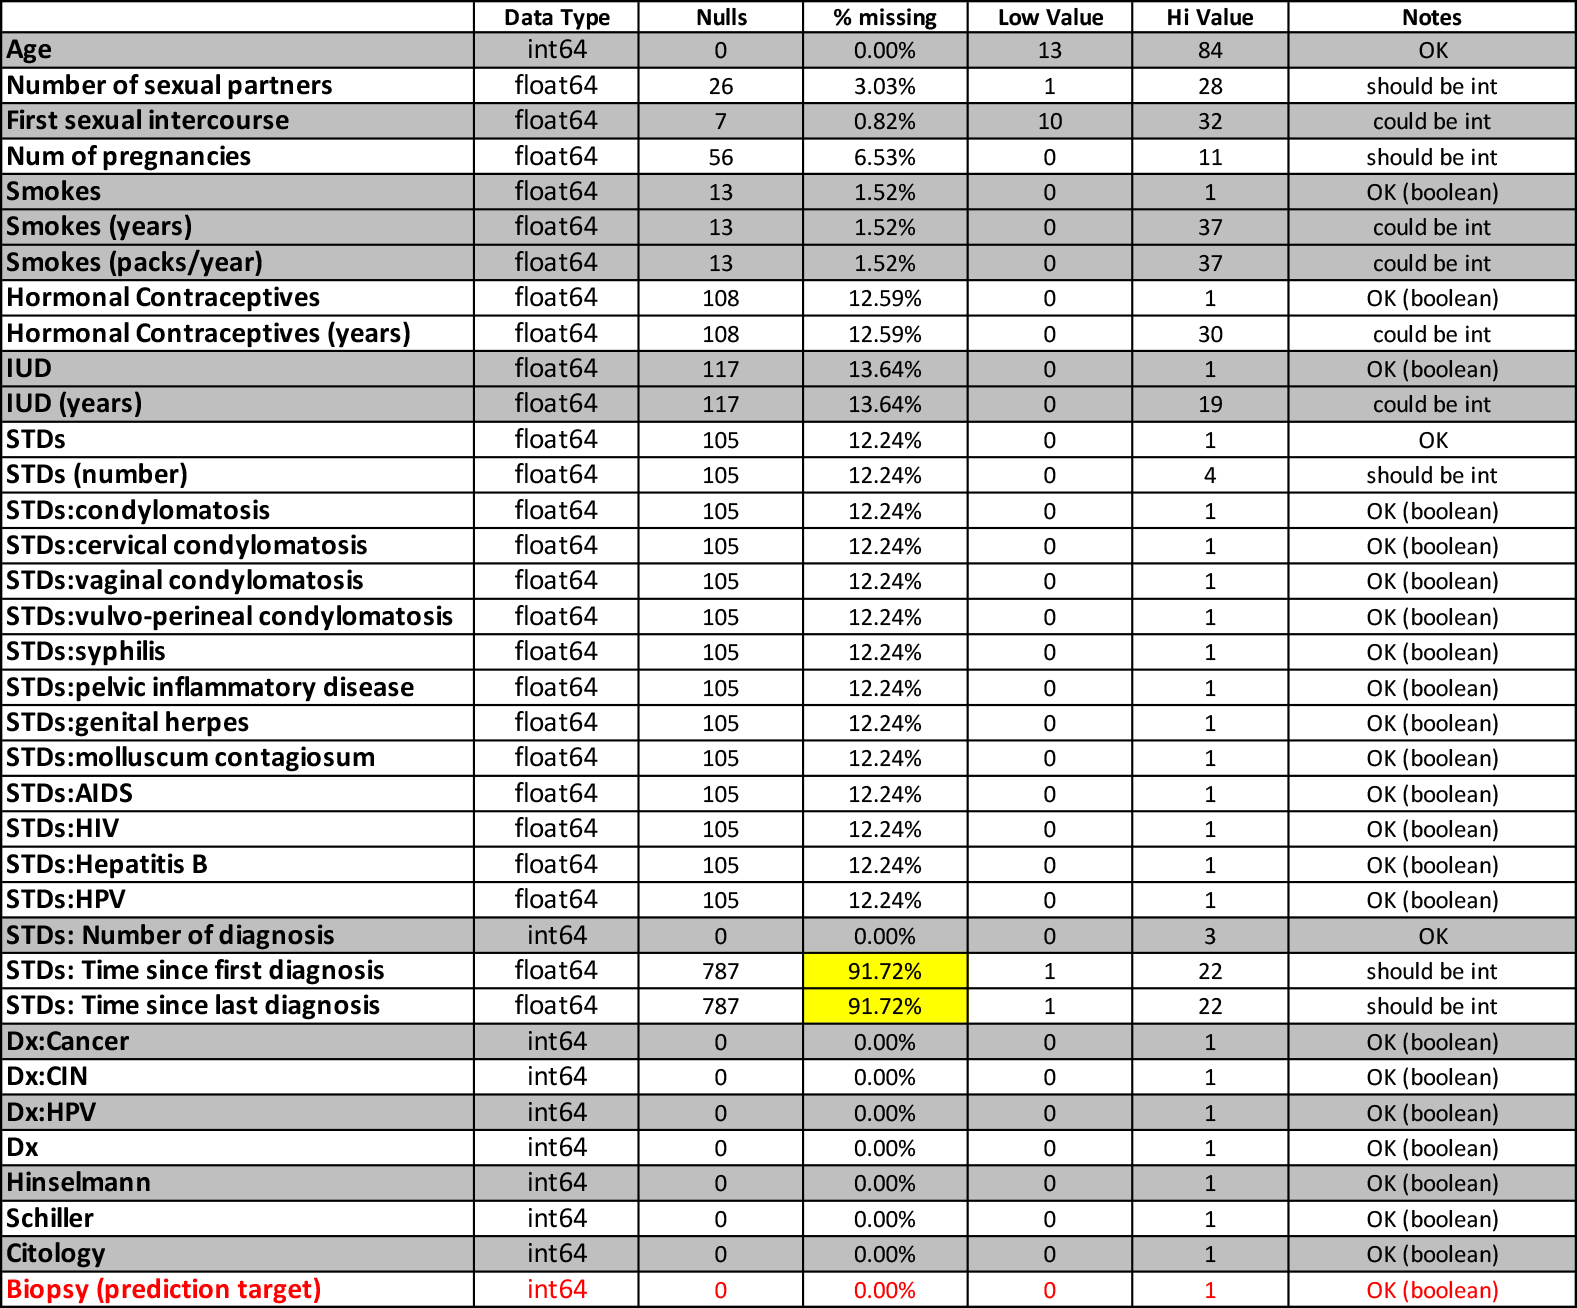

Because I do not want to lose any information that may be present in the records with missing values for these factors:
* Number of sexual partners
* First sexual intercourse
* Num of pregnancies

I chose to create new factors to retain the information. These factors will have a value of true (1) if the record had a value and a value of false (0) if the record was missing data for that field:
* is_first_intercourse_known
* is_first_intercourse_known
* is_number_pregnancies_known


In [41]:
# function to create a new boolean column in a df
# given a column with int, float, and/or numpy.nan values.
# if any value was present the output value will be "1", if no value was present the output value will be "0".

def new_bool(df, col_name):
    bool_list = []
    for index, row in df.iterrows():
#         print(row)
        value = row[col_name]
#         print(value)
        value_out = 1  # originally used value_out = np.True
        if pd.isna(value):
            value_out = 0  # originally used value_out = np.False
            
#       for testing
#         print("value: {}   -   bool: {}".format(value, str(value_out)))

        bool_list.append(value_out)

    return bool_list

#       for testing
#         print("value: {}   -   bool: {}".format(value, str(row[new_col_name])))


In [42]:
# create new factor 'is_number_partners_known'
df['is_number_partners_known'] = new_bool(df, 'Number of sexual partners')

In [43]:
# check if operation was successful
df['is_number_partners_known'].value_counts(dropna=False)

1    832
0     26
Name: is_number_partners_known, dtype: int64

In [44]:
# create new factor 'is_first_intercourse_known'
df['is_first_intercourse_known'] = new_bool(df, 'First sexual intercourse')

In [45]:
# check if operation was successful
df['is_first_intercourse_known'].value_counts(dropna=False)

1    851
0      7
Name: is_first_intercourse_known, dtype: int64

In [46]:
# create new factor 'is_number_pregnancies_known'
df['is_number_pregnancies_known'] = new_bool(df, 'Num of pregnancies')

In [47]:
# check if operation was successful
df['is_number_pregnancies_known'].value_counts(dropna=False)

1    802
0     56
Name: is_number_pregnancies_known, dtype: int64

Before I delete or fill missing values for any factors I will make a copy of the dataset and continue work on the new copy. This is useful if I ever want or need to revert to the dataset as it exists at this stage.

In [78]:
df2 = df.copy(deep=True)

These factors are missing values for over 90% of the records:
* STDs: Time since first diagnosis
* STDs: Time since last diagnosis

I will delete the records missing values for these records but before doing so I want to examine the distribution of the related factor "STDs: Number of diagnosis".


In [79]:
df2['STDs: Number of diagnosis'].value_counts(dropna=False)

0    787
1     68
2      2
3      1
Name: STDs: Number of diagnosis, dtype: int64

Over 90% of the records have a zero value for this factor and I am assuming that this means that the patient had never been diagnosed with an STD. Because there may be some useful information in the remaining 71 records that have a values of 1, 2, or 3, I will leave this factor as is. It appears that the 787 records that have a value of zero for this factor are the same 787 records missing values for the two "time since..." factors.

In [80]:
# subset the records where the value is zero for 'STDs: Number of diagnosis'
value_zero = df2['STDs: Number of diagnosis'] == 0
temp = df2[value_zero]

print('time since first: ', temp['STDs: Time since first diagnosis'].value_counts(dropna=False))
print('time since last: ', temp['STDs: Time since last diagnosis'].value_counts(dropna=False))

time since first:  NaN    787
Name: STDs: Time since first diagnosis, dtype: int64
time since last:  NaN    787
Name: STDs: Time since last diagnosis, dtype: int64


This confirms that the 787 records missing values for the two "time since..." factors are indeed the records with a zero for "STDs: Number of diagnosis". I will replace these missing values with a zero.

In [83]:
df2['STDs: Time since first diagnosis'].fillna(0, inplace=True)
df2['STDs: Time since first diagnosis'].value_counts(dropna=False)

0.0     787
1.0      15
3.0      10
2.0       9
4.0       6
7.0       5
5.0       4
16.0      4
6.0       3
8.0       3
19.0      2
21.0      2
11.0      2
15.0      1
18.0      1
12.0      1
22.0      1
10.0      1
9.0       1
Name: STDs: Time since first diagnosis, dtype: int64

In [84]:
df2['STDs: Time since last diagnosis'].fillna(0, inplace=True)
df2['STDs: Time since last diagnosis'].value_counts(dropna=False)

0.0     787
1.0      17
2.0      10
3.0       9
4.0       6
7.0       5
16.0      4
5.0       3
6.0       3
8.0       3
21.0      2
11.0      2
19.0      1
15.0      1
18.0      1
12.0      1
22.0      1
10.0      1
9.0       1
Name: STDs: Time since last diagnosis, dtype: int64

The three factors relate to smoking are missing values in less than 2% of the records. I will replace these missing values with a zero. This is expected to have a minimal effect on the models.

Smokes, Hormonal Contraceptives, IUD, and STDs are all boolean factors with missing values. Look at the distribution of the values in these factors:


In [89]:
col_list = ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs']

for col in col_list:
    print(col,':')
    print(df2[col].value_counts(dropna=False))
    print("----------------")

Smokes :
0.0    722
1.0    123
NaN     13
Name: Smokes, dtype: int64
----------------
Hormonal Contraceptives :
1.0    481
0.0    269
NaN    108
Name: Hormonal Contraceptives, dtype: int64
----------------
IUD :
0.0    658
NaN    117
1.0     83
Name: IUD, dtype: int64
----------------
STDs :
0.0    674
NaN    105
1.0     79
Name: STDs, dtype: int64
----------------


I chose to fill the missing values in each factor with the value (true/false) having the highest frequency.

In [93]:
# replace missing values and confirm results
df2['Smokes'].fillna(0, inplace=True)
df2['Hormonal Contraceptives'].fillna(1, inplace=True)
df2['IUD'].fillna(0, inplace=True)
df2['STDs'].fillna(0, inplace=True)

for col in col_list:
    print(col,':')
    print(df2[col].value_counts(dropna=False))
    print("----------------")

Smokes :
0.0    735
1.0    123
Name: Smokes, dtype: int64
----------------
Hormonal Contraceptives :
1.0    589
0.0    269
Name: Hormonal Contraceptives, dtype: int64
----------------
IUD :
0.0    775
1.0     83
Name: IUD, dtype: int64
----------------
STDs :
0.0    779
1.0     79
Name: STDs, dtype: int64
----------------


The following factors are integer values and all have relatively few missing values:
* Number of sexual partners
* First sexual intercourse
* Num of pregnancies
* Smokes (years)
* Smokes (packs/year)
* Hormonal Contraceptives (years)
* IUD (years)
* STDs (number)

Next step, looking more closely at the distribution of values in each of these factors and subsequently deciding how to fill the missing values.

In [185]:
# create a function to display a countplot, boxplot, and summary stats for a factor

def countplot_boxplot(column, dataframe):
    fig = plt.figure(figsize=(15,20))
    fig.suptitle(column, size=20)
    
    ax1 = fig.add_subplot(2,1,1)
    sns.countplot(dataframe[column])
#     plt.title(column)
    plt.xticks(rotation=45)

    ax2 = fig.add_subplot(2,1,2)
    sns.boxplot(dataframe[column])
#     plt.title(column)
    plt.xticks(rotation=45)
    plt.show()
    
    print('Min:', df2[column].min())
    print('Mean:', df2[column].mean())
    print('Median:', df2[column].median())
    print('Mode:', df2[column].mode()[0])
    print('Max:', df2[column].max())
    print('**********************')
    print('% of values missing:', (df2[column].isna().sum() / len(df2))*100)


# create a function to replace missing values with the median

def fillna_median(column, dataframe):
    dataframe[column].fillna(dataframe[column].median(), inplace=True)
    print (dataframe[column].value_counts(dropna=False))


# create a function to replace missing values with zeros

def fillna_zeros(column, dataframe):
    dataframe[column].fillna(0, inplace=True)
    print(dataframe[column].value_counts(dropna=False) )   

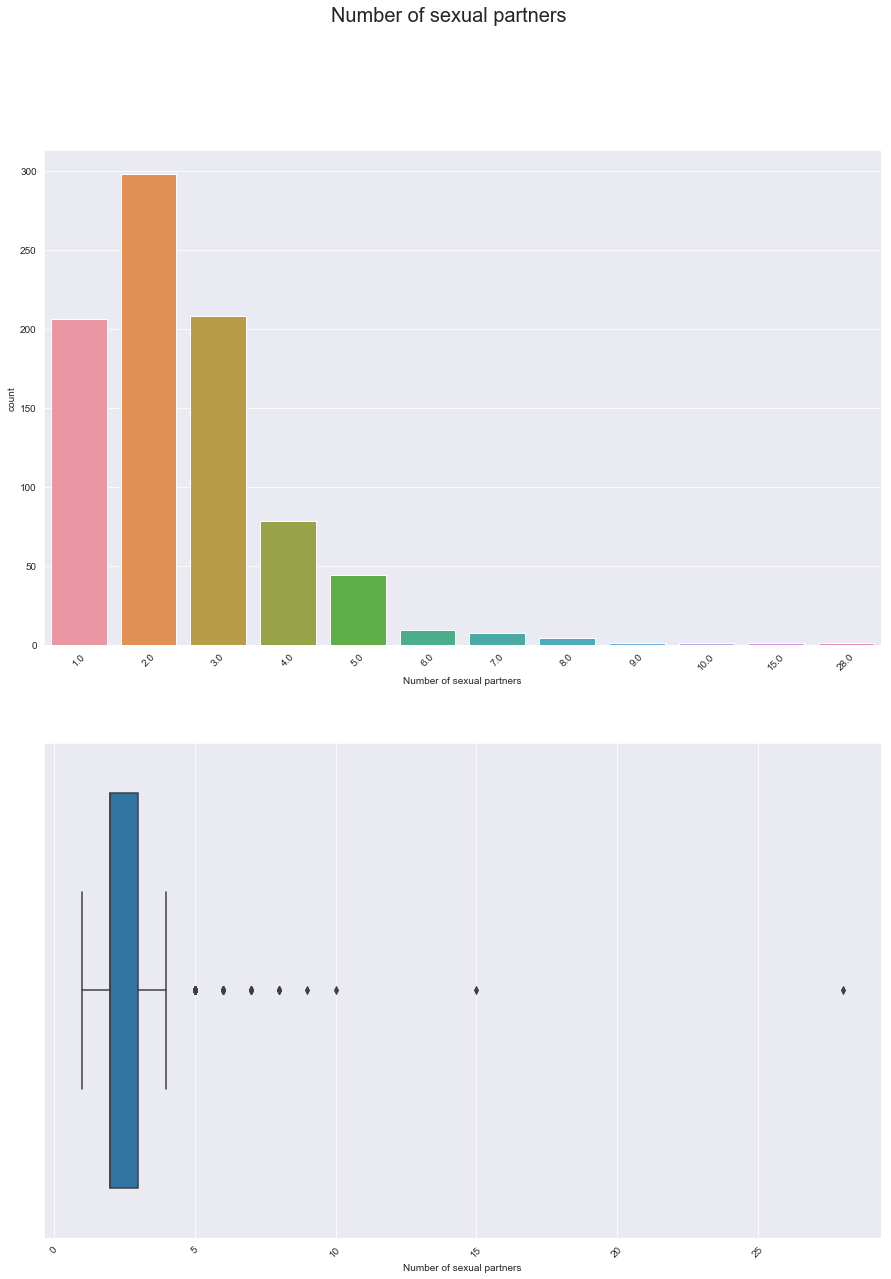

Min: 1.0
Mean: 2.511655011655012
Median: 2.0
Mode: 2.0
Max: 28.0
**********************
% of values missing: 0.0


In [186]:
countplot_boxplot('Number of sexual partners', df2)

The mean of 'Number of sexual partners' is pulled higher by some outliers. I will replace the missing values with 2.0 which is both the mode and the median value.

In [187]:
# replace with median
fillna_median('Number of sexual partners', df2)

# df2['Number of sexual partners'].fillna(df2['Number of sexual partners'].median(), inplace=True)
# df2['Number of sexual partners'].value_counts(dropna=False)


2.0     298
3.0     208
1.0     206
4.0      78
5.0      44
6.0       9
7.0       7
8.0       4
9.0       1
28.0      1
10.0      1
15.0      1
Name: Number of sexual partners, dtype: int64


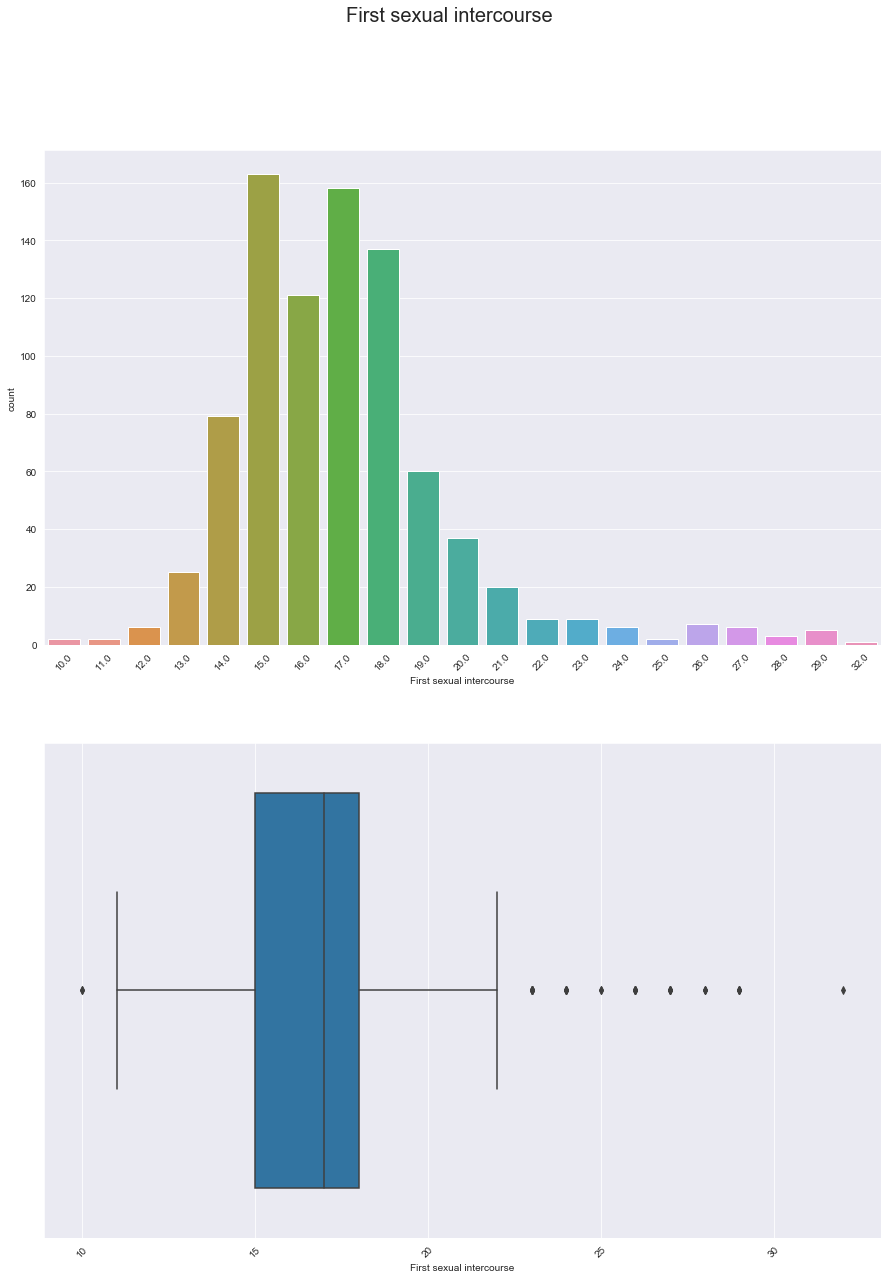

Min: 10.0
Mean: 16.995337995337994
Median: 17.0
Mode: 15.0
Max: 32.0
**********************
% of values missing: 0.0


In [168]:
countplot_boxplot('First sexual intercourse', df2)


A very small percentage of values are missing for this factor. I will replace those with the median value.

In [188]:
# replace with median
fillna_median('First sexual intercourse', df2)
# df2['First sexual intercourse'].fillna(df2['First sexual intercourse'].median(), inplace=True)
# df2['First sexual intercourse'].value_counts(dropna=False)


15.0    163
17.0    158
18.0    137
16.0    121
14.0     79
19.0     60
20.0     37
13.0     25
21.0     20
22.0      9
23.0      9
26.0      7
27.0      6
24.0      6
12.0      6
29.0      5
28.0      3
25.0      2
11.0      2
10.0      2
32.0      1
Name: First sexual intercourse, dtype: int64


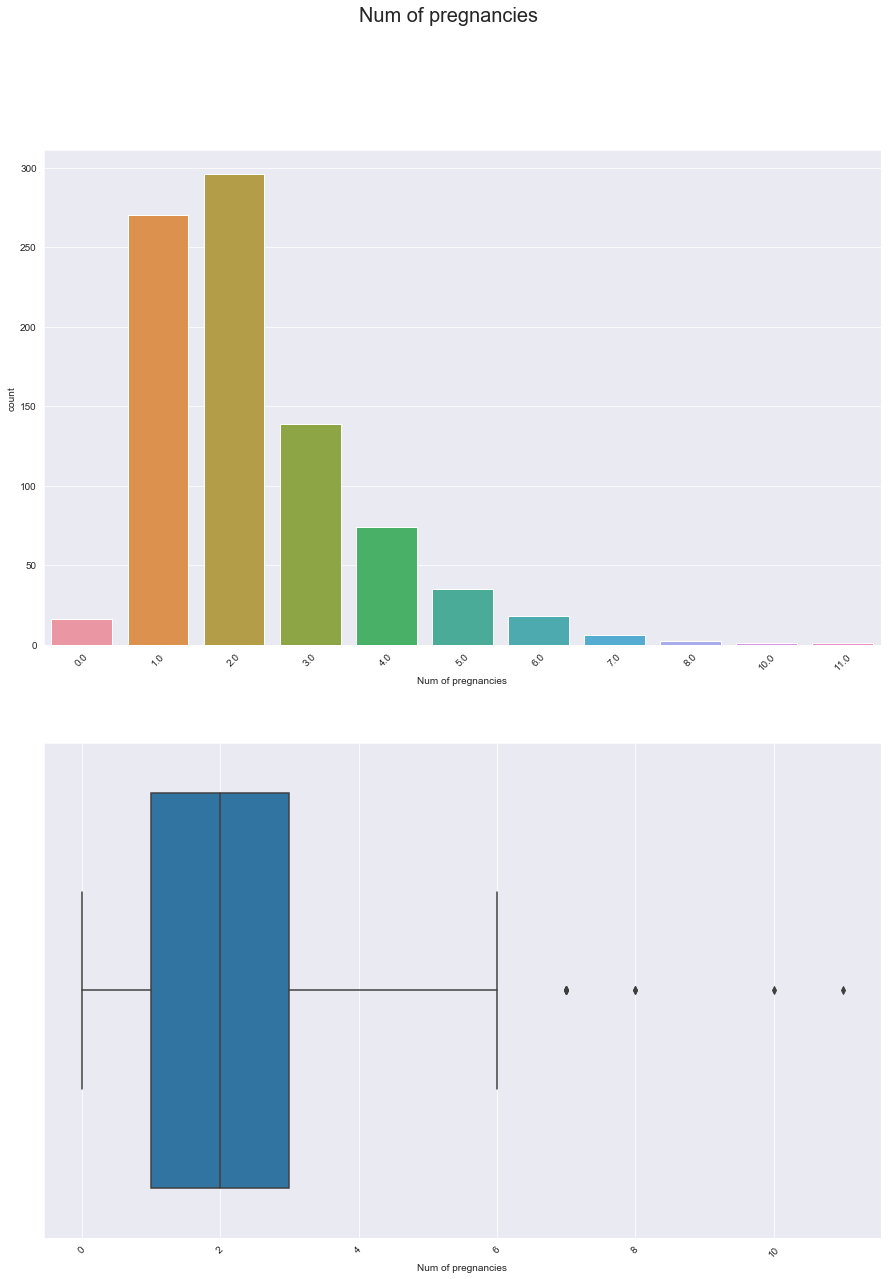

Min: 0.0
Mean: 2.257575757575758
Median: 2.0
Mode: 2.0
Max: 11.0
**********************
% of values missing: 0.0


In [189]:
countplot_boxplot('Num of pregnancies', df2)

About 6.5% of the values are missing and I will replace those values with the median.

In [190]:
# replace with median
fillna_median('Num of pregnancies', df2)
# df2['Num of pregnancies'].fillna(df2['Num of pregnancies'].median(), inplace=True)
# df2['Num of pregnancies'].value_counts(dropna=False)

2.0     296
1.0     270
3.0     139
4.0      74
5.0      35
6.0      18
0.0      16
7.0       6
8.0       2
10.0      1
11.0      1
Name: Num of pregnancies, dtype: int64


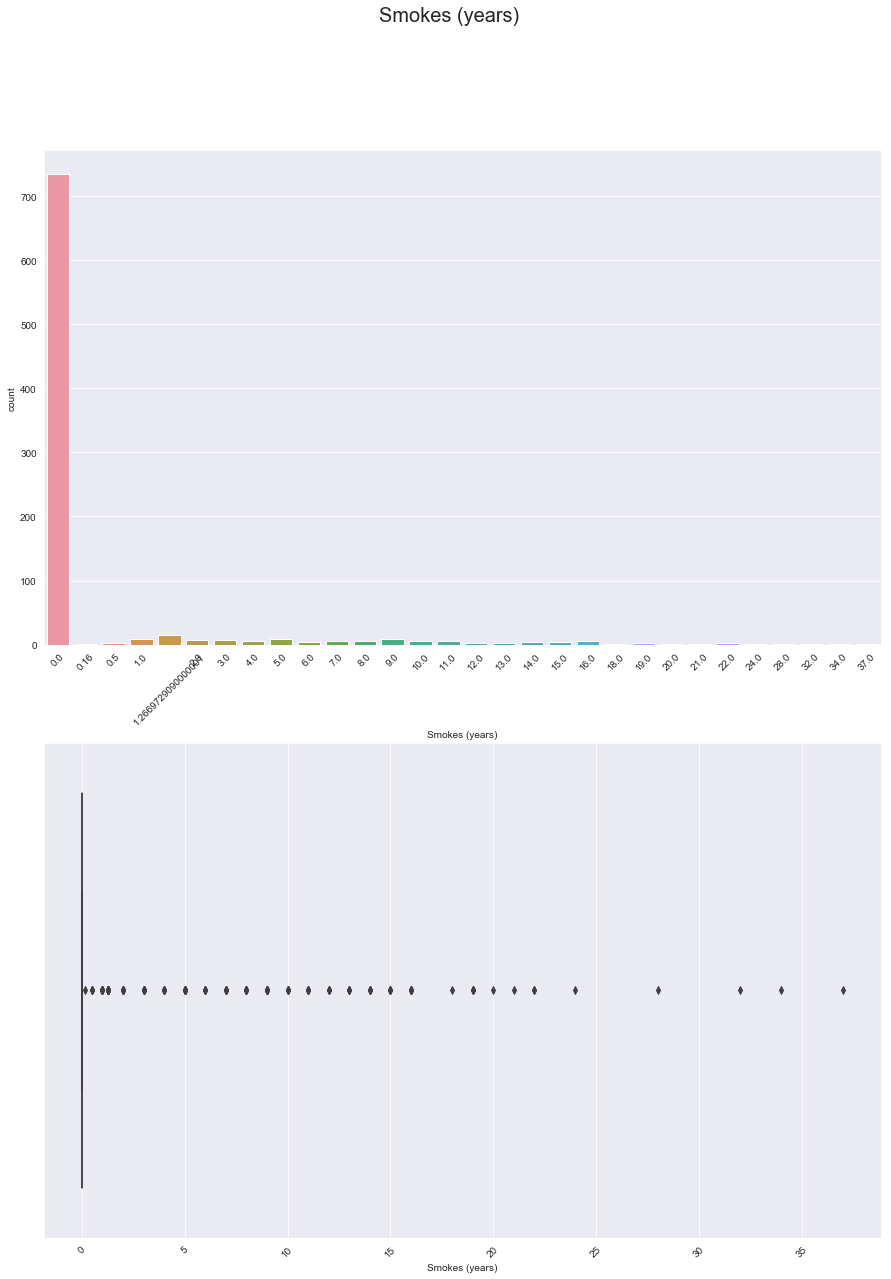

Min: 0.0
Mean: 1.2012407851223772
Median: 0.0
Mode: 0.0
Max: 37.0
**********************
% of values missing: 0.0


In [172]:
countplot_boxplot('Smokes (years)', df2)

Since less than 2% of the values are missing and the overwhelming majority of the values are zero, I will replace the missing values with zero.

In [195]:
# replace with zeros
fillna_zeros('Smokes (years)', df2)
# df2['Smokes (years)'].fillna(0, inplace=True)
# df2['Smokes (years)'].value_counts(dropna=False)

0.000000     735
1.266973      15
5.000000       9
9.000000       9
1.000000       8
3.000000       7
2.000000       7
7.000000       6
16.000000      6
8.000000       6
4.000000       5
10.000000      5
11.000000      5
6.000000       4
15.000000      4
14.000000      4
0.500000       3
12.000000      3
13.000000      3
19.000000      3
22.000000      2
37.000000      1
34.000000      1
20.000000      1
21.000000      1
18.000000      1
28.000000      1
24.000000      1
32.000000      1
0.160000       1
Name: Smokes (years), dtype: int64


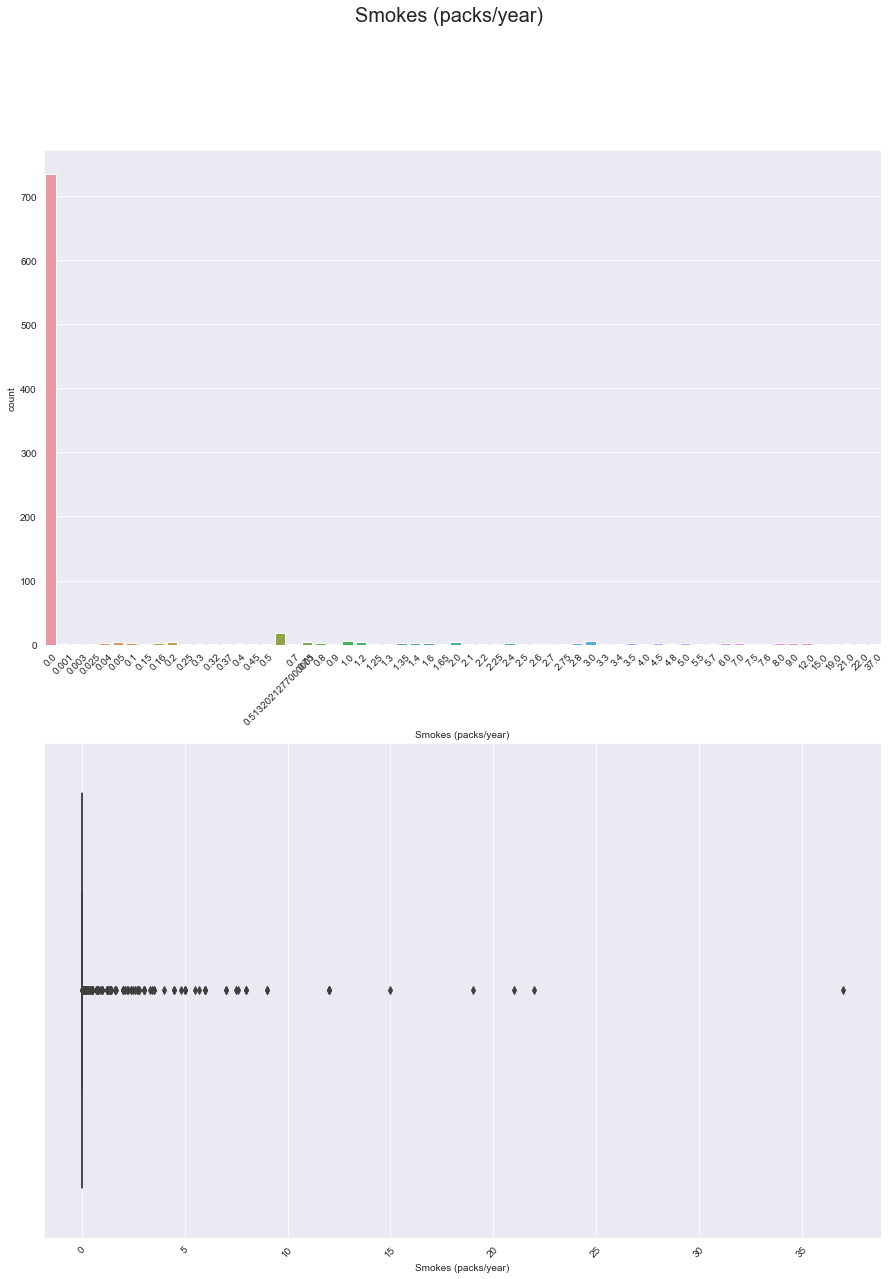

Min: 0.0
Mean: 0.4462781332151517
Median: 0.0
Mode: 0.0
Max: 37.0
**********************
% of values missing: 0.0


In [196]:
countplot_boxplot('Smokes (packs/year)', df2)

Similar to the "Smokes (years) factor, this factor has less than 2% missing and most values are zero. I will replace the missing values with zero.

In [197]:
# replace with zeros
fillna_zeros('Smokes (packs/year)', df2)
# df2['Smokes (packs/year)'].fillna(0, inplace=True)
# df2['Smokes (packs/year)'].value_counts(dropna=False)

0.000000     735
0.513202      18
1.000000       6
3.000000       5
0.050000       4
2.000000       4
0.750000       4
1.200000       4
0.200000       4
0.100000       3
6.000000       3
12.000000      3
5.000000       3
7.000000       2
0.040000       2
1.350000       2
2.800000       2
1.600000       2
1.400000       2
8.000000       2
2.400000       2
4.500000       2
0.160000       2
3.500000       2
0.800000       2
9.000000       2
1.250000       1
0.500000       1
2.250000       1
7.500000       1
            ... 
21.000000      1
19.000000      1
0.250000       1
37.000000      1
22.000000      1
1.300000       1
2.500000       1
4.000000       1
0.150000       1
5.700000       1
0.320000       1
7.600000       1
0.700000       1
3.300000       1
0.003000       1
0.900000       1
4.800000       1
2.600000       1
3.400000       1
2.700000       1
2.200000       1
0.400000       1
0.450000       1
0.300000       1
0.025000       1
1.650000       1
0.001000       1
0.370000      

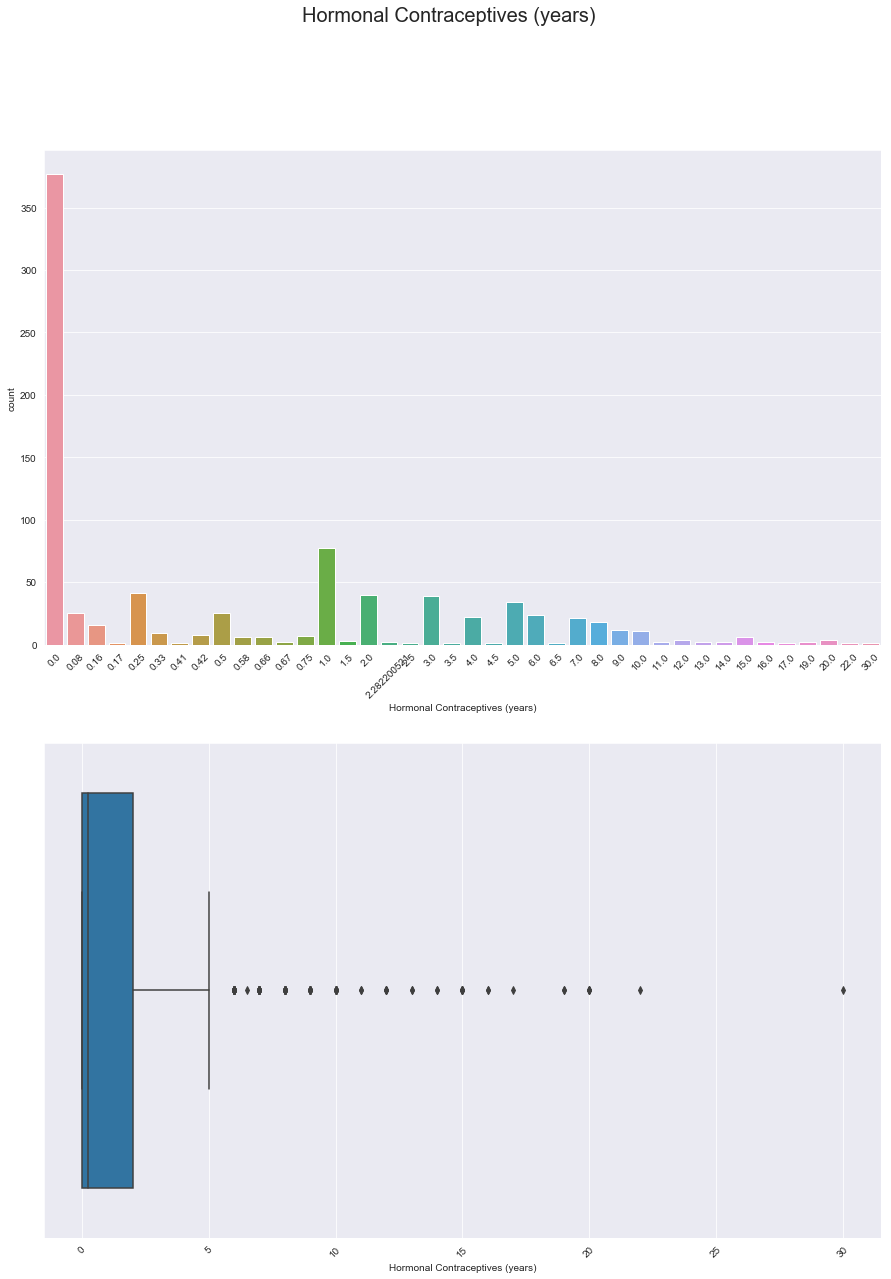

Min: 0.0
Mean: 1.9723944068088588
Median: 0.25
Mode: 0.0
Max: 30.0
**********************
% of values missing: 0.0


In [198]:
countplot_boxplot('Hormonal Contraceptives (years)', df2)

About 12.6% of the records are missing values for this factor, records with a zero value are by far the largest group, and there are quite a few outliers, all falling in the higher value range. These high outliers pull the mean substantially higher than the median. An argument could be made to fill the missing values with either the mode (0) or the median (0.5). I chose to fill them with zeros.

In [199]:
# replace with zeros
fillna_zeros('Hormonal Contraceptives (years)', df2)
# df2['Hormonal Contraceptives (years)'].fillna(0, inplace=True)
# df2['Hormonal Contraceptives (years)'].value_counts(dropna=False)

0.000000     377
1.000000      77
0.250000      41
2.000000      40
3.000000      39
5.000000      34
0.500000      25
0.080000      25
6.000000      24
4.000000      22
7.000000      21
8.000000      18
0.160000      16
9.000000      12
10.000000     11
0.330000       9
0.420000       8
0.750000       7
0.580000       6
15.000000      6
0.660000       6
20.000000      4
12.000000      4
1.500000       3
19.000000      2
0.670000       2
11.000000      2
14.000000      2
13.000000      2
16.000000      2
2.282201       2
0.170000       1
22.000000      1
2.500000       1
4.500000       1
6.500000       1
3.500000       1
30.000000      1
17.000000      1
0.410000       1
Name: Hormonal Contraceptives (years), dtype: int64


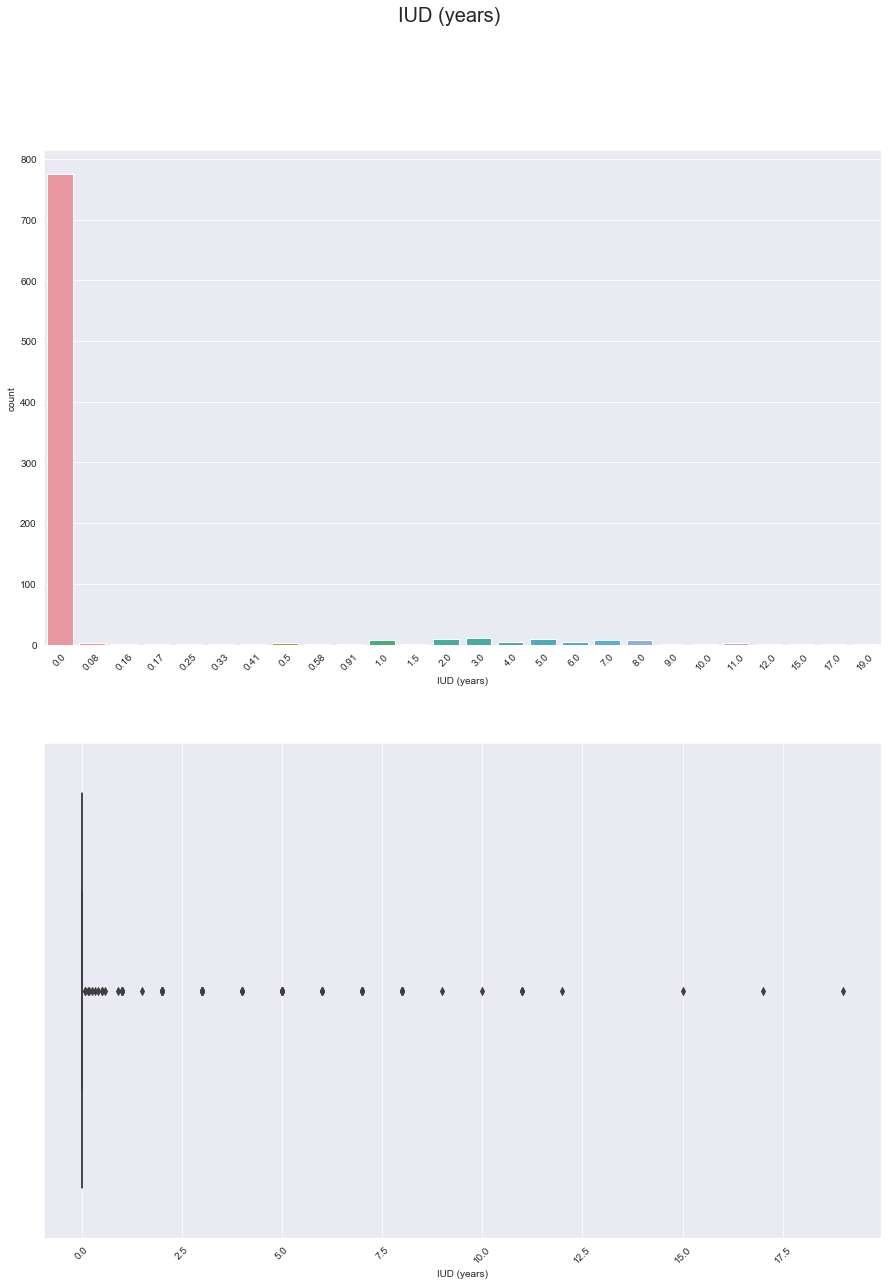

Min: 0.0
Mean: 0.4446037296037296
Median: 0.0
Mode: 0.0
Max: 19.0
**********************
% of values missing: 0.0


In [200]:
countplot_boxplot('IUD (years)', df2)

Zero is very clearly the best choice to fill the missing values for this factor.

In [201]:
# replace with zeros
fillna_zeros('IUD (years)', df2)
# df2['IUD (years)'].fillna(0, inplace=True)
# df2['IUD (years)'].value_counts(dropna=False)

0.00     775
3.00      11
2.00      10
5.00       9
1.00       8
7.00       7
8.00       7
6.00       5
4.00       5
11.00      3
0.50       2
0.08       2
12.00      1
15.00      1
9.00       1
0.33       1
10.00      1
0.25       1
17.00      1
19.00      1
1.50       1
0.17       1
0.41       1
0.58       1
0.91       1
0.16       1
Name: IUD (years), dtype: int64


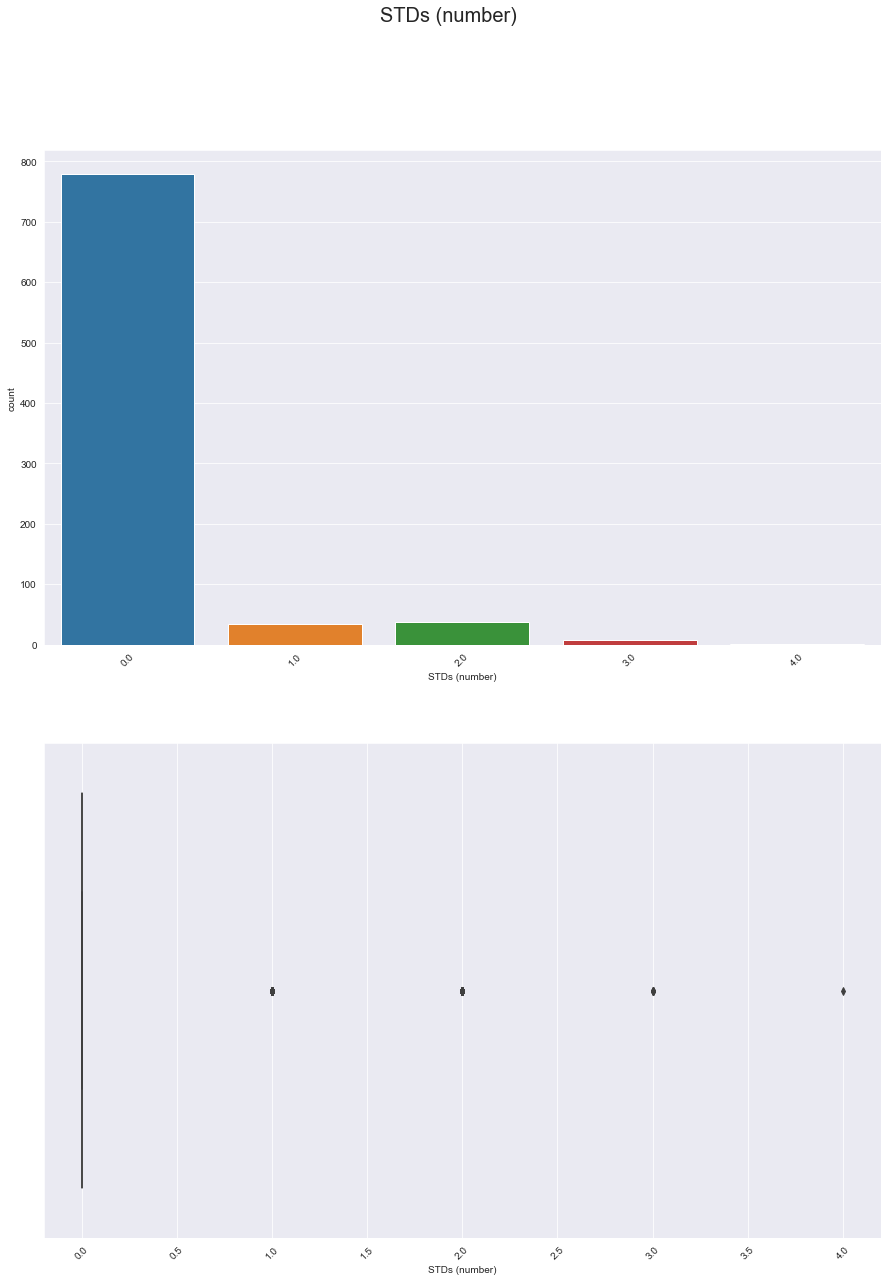

Min: 0.0
Mean: 0.155011655011655
Median: 0.0
Mode: 0.0
Max: 4.0
**********************
% of values missing: 0.0


In [202]:
countplot_boxplot('STDs (number)', df2)

I chose to replace the approximately 12% of missing values in this factor with zeros because zero is both the median and the mode.


In [203]:
# replace with zeros
fillna_zeros('STDs (number)', df2)
# df2['STDs (number)'].fillna(0, inplace=True)
# df2['STDs (number)'].value_counts(dropna=False)

0.0    779
2.0     37
1.0     34
3.0      7
4.0      1
Name: STDs (number), dtype: int64


12 individual STD factors are boolean and missing about 12% of the values. Because I replaced the missing values in the "STDs (number)" factor with zeros, I will also replace the missing values in each of these factors with zero.

In [204]:
# replace missing values with a zero
col_list = [
    'STDs:condylomatosis',
    'STDs:cervical condylomatosis',
    'STDs:vaginal condylomatosis',
    'STDs:vulvo-perineal condylomatosis',
    'STDs:syphilis',
    'STDs:pelvic inflammatory disease',
    'STDs:genital herpes',
    'STDs:molluscum contagiosum',
    'STDs:AIDS',
    'STDs:HIV',
    'STDs:Hepatitis B',
    'STDs:HPV']


for col in col_list:
    fillna_zeros(col, df2)


0.0    814
1.0     44
Name: STDs:condylomatosis, dtype: int64
0.0    858
Name: STDs:cervical condylomatosis, dtype: int64
0.0    854
1.0      4
Name: STDs:vaginal condylomatosis, dtype: int64
0.0    815
1.0     43
Name: STDs:vulvo-perineal condylomatosis, dtype: int64
0.0    840
1.0     18
Name: STDs:syphilis, dtype: int64
0.0    857
1.0      1
Name: STDs:pelvic inflammatory disease, dtype: int64
0.0    857
1.0      1
Name: STDs:genital herpes, dtype: int64
0.0    857
1.0      1
Name: STDs:molluscum contagiosum, dtype: int64
0.0    858
Name: STDs:AIDS, dtype: int64
0.0    840
1.0     18
Name: STDs:HIV, dtype: int64
0.0    857
1.0      1
Name: STDs:Hepatitis B, dtype: int64
0.0    856
1.0      2
Name: STDs:HPV, dtype: int64


Two of these factors have no information:
* STDs:cervical condylomatosis
* STDs:AIDS

I dropped them from the dataframe.

In [205]:
# drop useless factors
df2.drop(['STDs:cervical condylomatosis','STDs:AIDS'], axis=1, inplace=True)

In [208]:
# look for any remaining NaN's in the dataframe
df2.isna().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0
STDs: Number of diagnosis             0
STDs: Time since first diagnosis      0


All missing values have now been dealt with. 

Next step: Exploratory Data Analysis

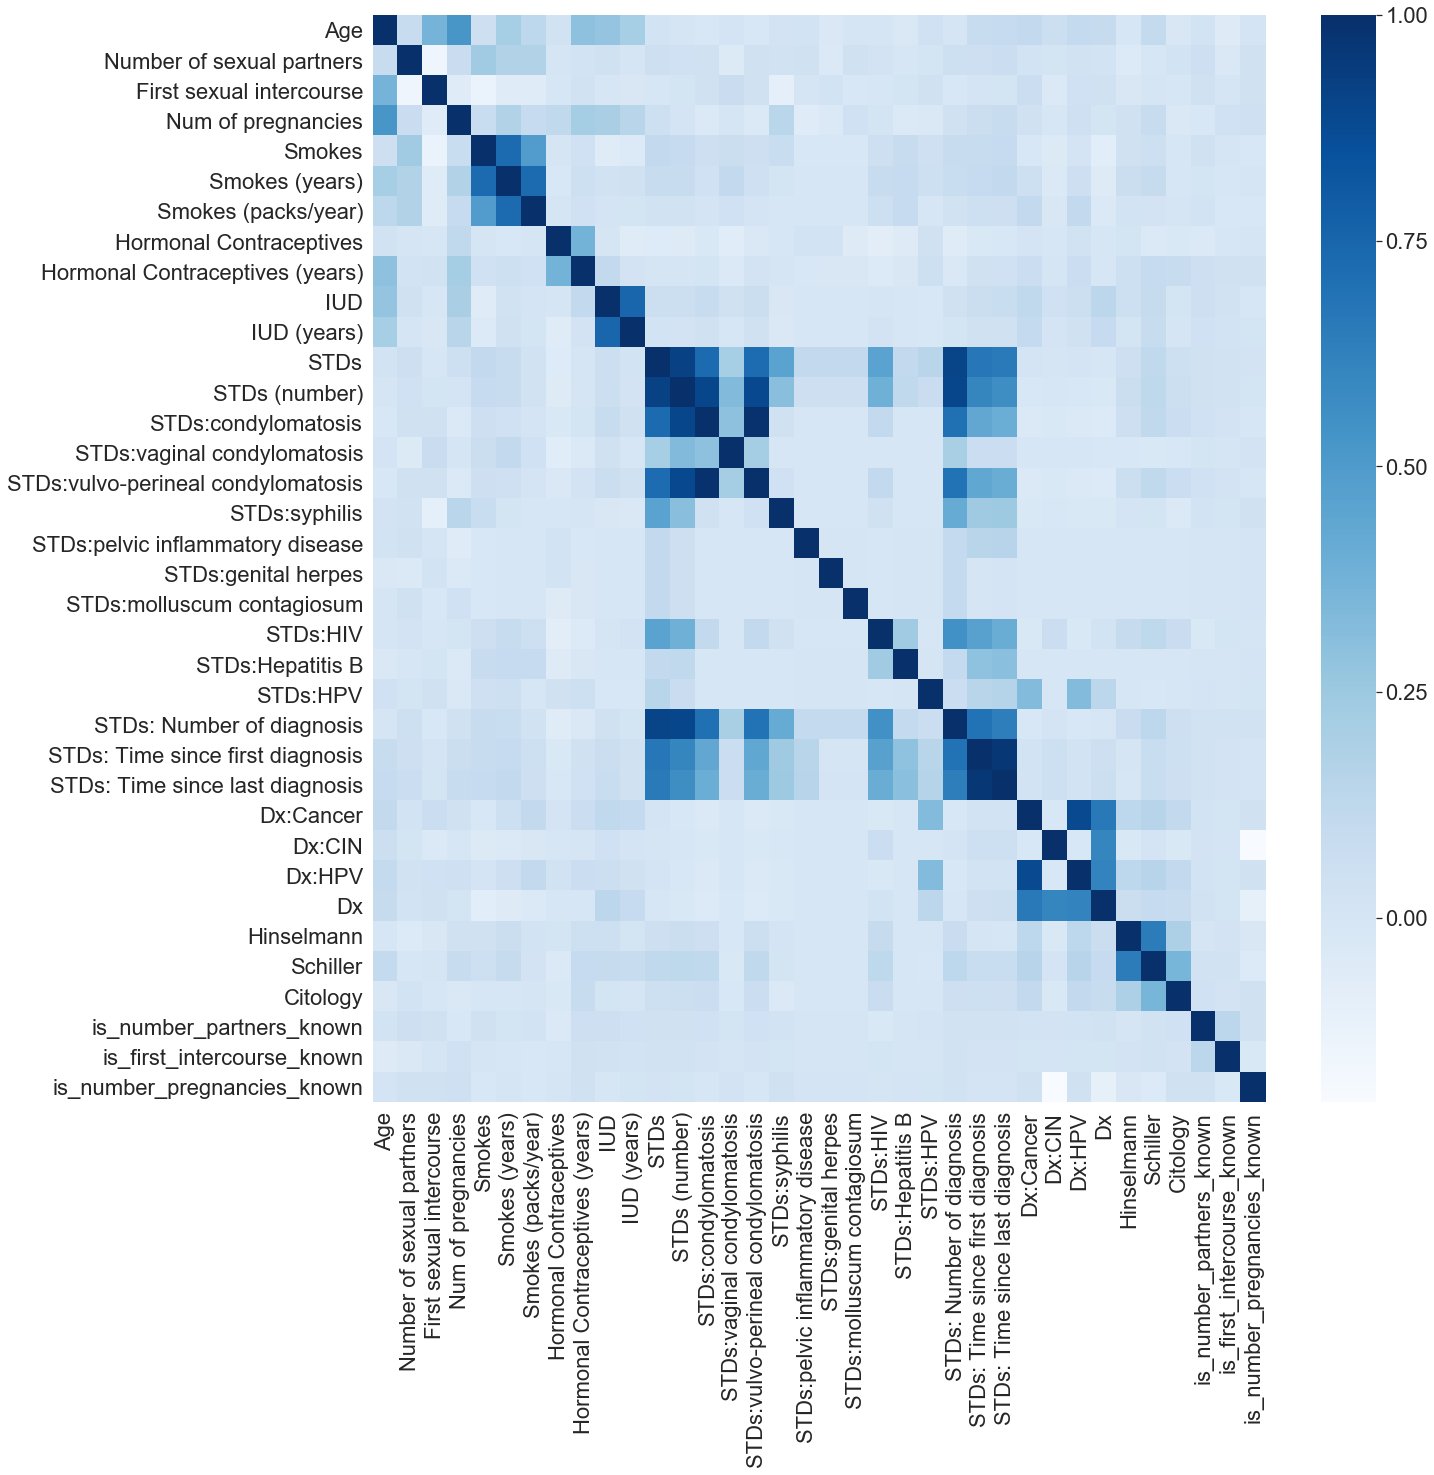

In [225]:
# pull the target variable from the dataframe and use a heatmap to look at possible correlations between factors
temp_df = df2.drop('Biopsy', axis=1)
f,ax = plt.subplots(figsize=(20,20))
sns.heatmap(temp_df.loc[:,:].corr(), annot=False, cmap="Blues", fmt='.1f' )
plt.show()

Soem factors show strong correlation but that is not surprising. For example, "STDs", "STDs (number)", and "STDs: Number of diagnosis", all show signifigant correlations to the individual STD factors. Additionally, the following factors all show some correlation with age:
* Number of sexual partners
* First sexual intercourse
* Number of pregnancies
* Smokes (years)
* Hormonal Contraceptives (years)
* IUD
* IUD (years)

It is not surprising that these factors would be correlated with a patients age.


In [228]:
# original heatmap
# f,ax = plt.subplots(figsize=(20,20))
# sns.heatmap(df2.loc[:,:].corr(), annot=True, cmap="Blues", fmt='.1f')
# plt.show()

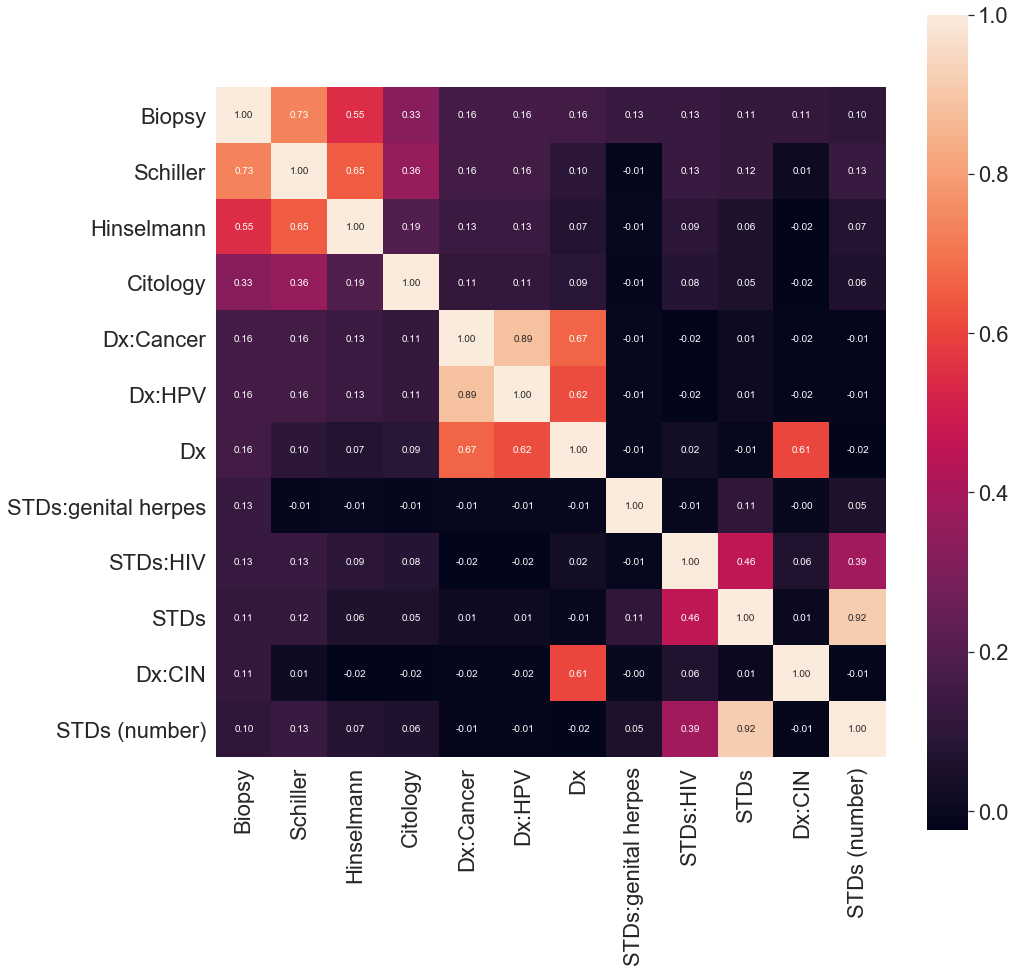

In [229]:
# look at a correlation matrix of the top 12 factors to the target variable: Biopsy

corrmat = df2.corr()
k = 12 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Biopsy')['Biopsy'].index
cm = np.corrcoef(df2[cols].values.T)

plt.figure(figsize=(15,15))

sns.set(font_scale=2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values)
plt.show()

Schiller, Hinselmann, and Citology are factors that represent medical diagnostic tools used to identify cervical cancer. It's not surprising they have the strongest correlations with Biopsy.

In [230]:
# make a backup copy of df2 at this stage of processing
df_backup = df2.copy()

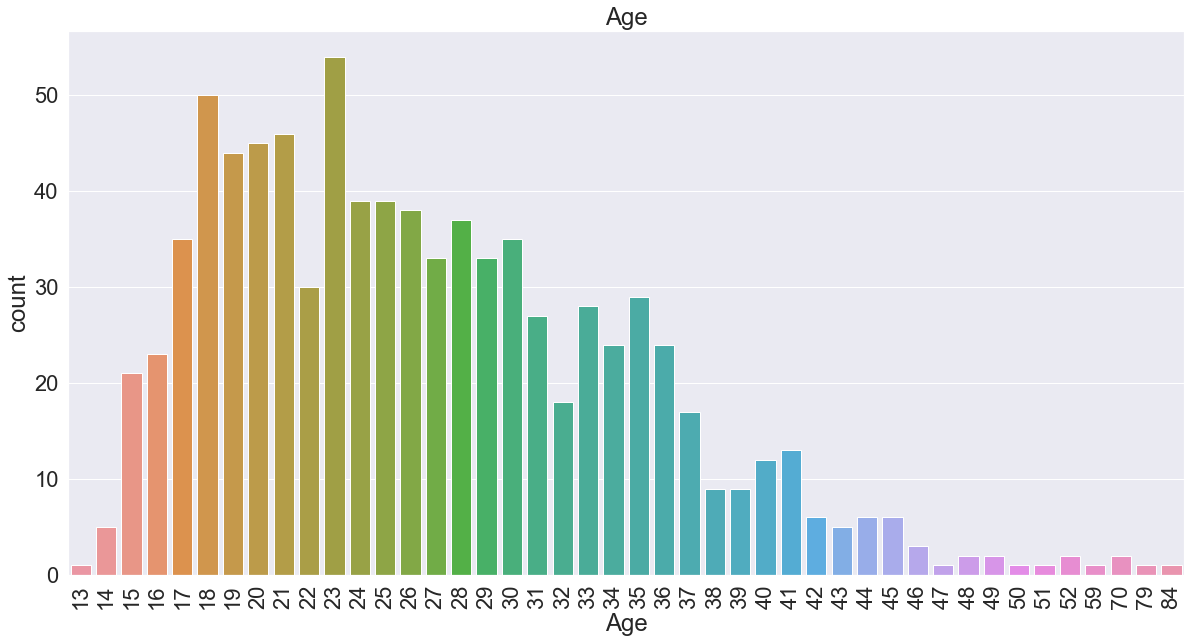



count    858.000000
mean      26.820513
std        8.497948
min       13.000000
25%       20.000000
50%       25.000000
75%       32.000000
max       84.000000
Name: Age, dtype: float64
************************************************


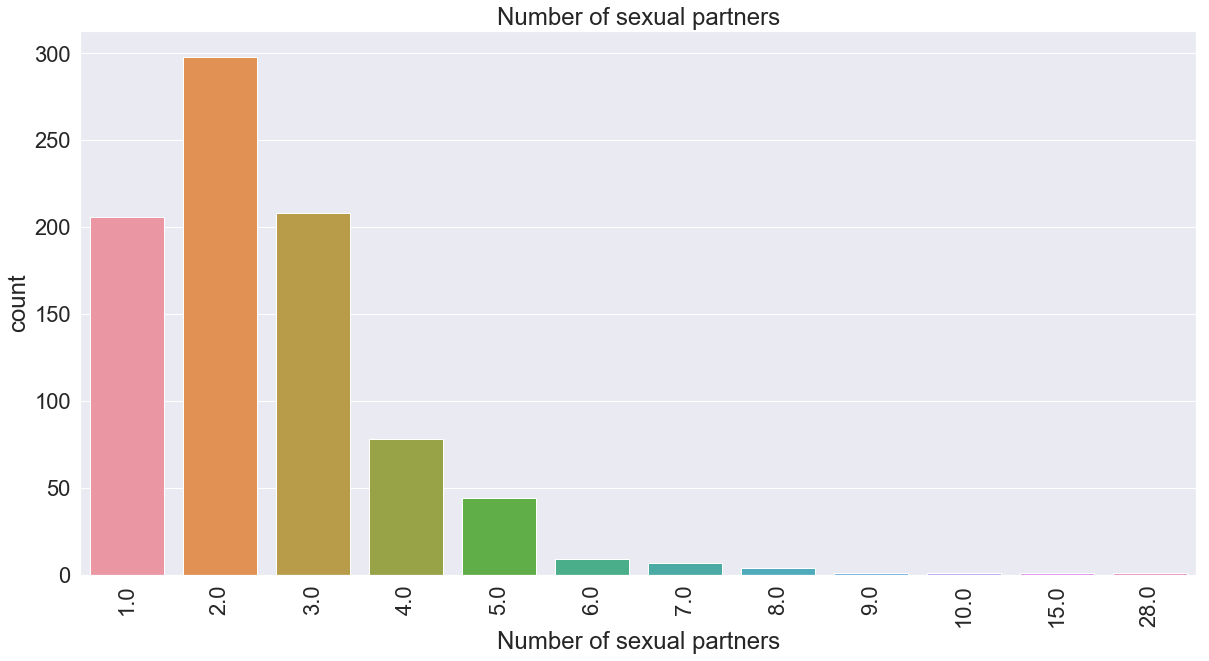



count    858.000000
mean       2.511655
std        1.644759
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       28.000000
Name: Number of sexual partners, dtype: float64
************************************************


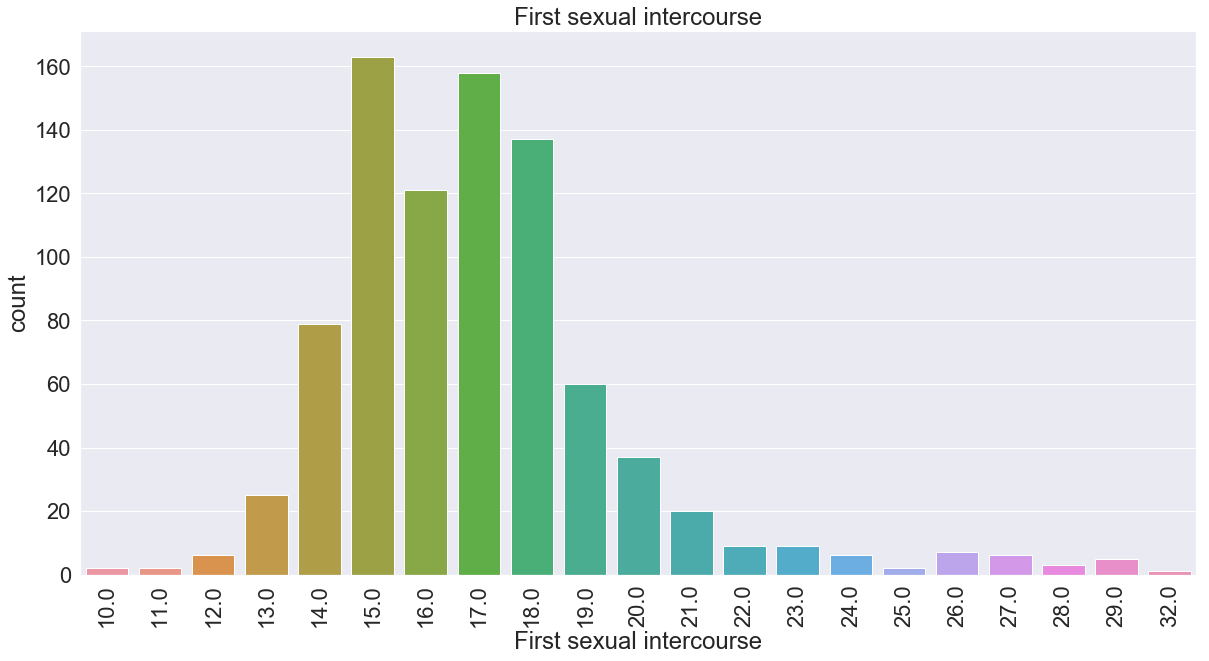



count    858.000000
mean      16.995338
std        2.791883
min       10.000000
25%       15.000000
50%       17.000000
75%       18.000000
max       32.000000
Name: First sexual intercourse, dtype: float64
************************************************


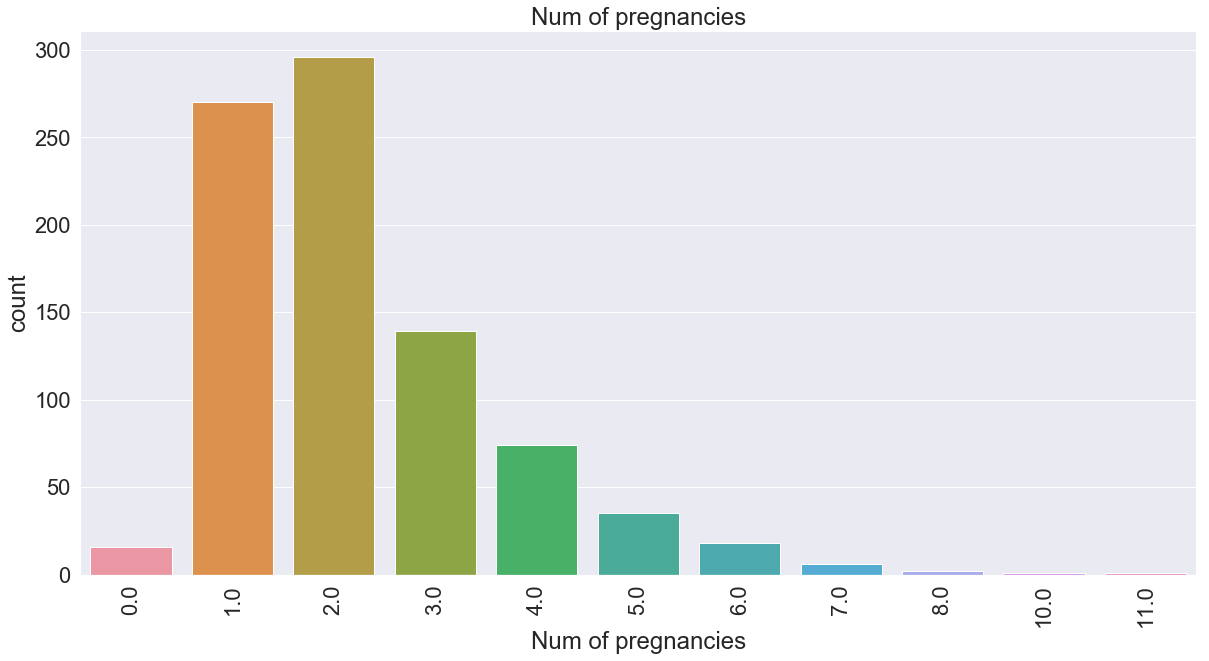



count    858.000000
mean       2.257576
std        1.400981
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       11.000000
Name: Num of pregnancies, dtype: float64
************************************************


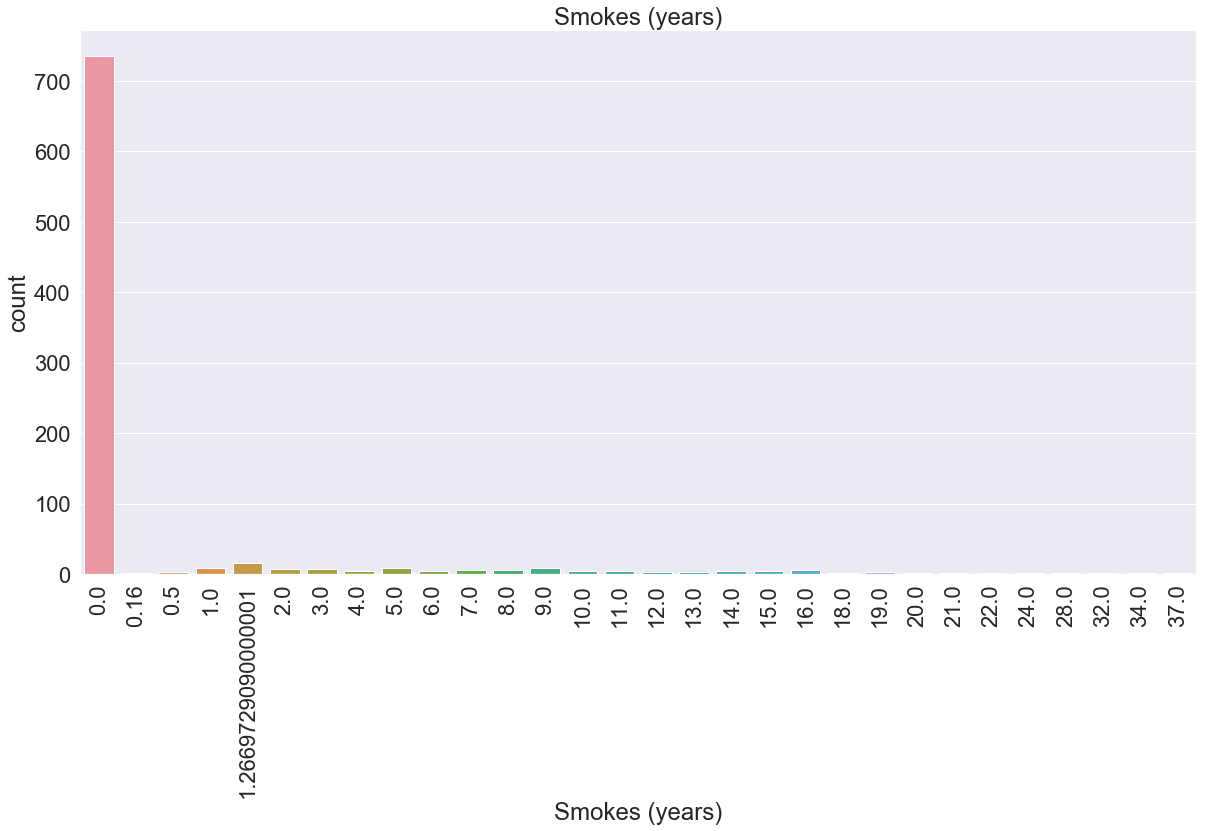



count    858.000000
mean       1.201241
std        4.060623
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       37.000000
Name: Smokes (years), dtype: float64
************************************************


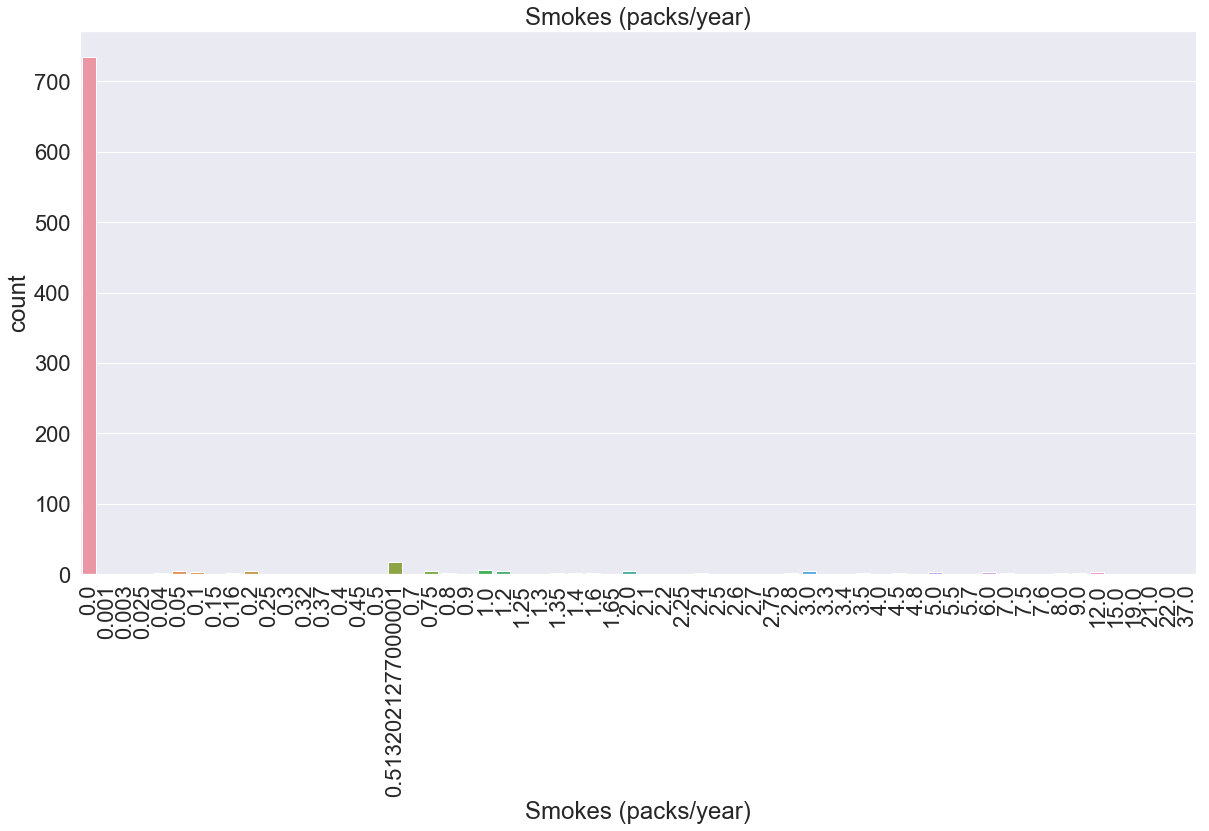



count    858.000000
mean       0.446278
std        2.210351
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       37.000000
Name: Smokes (packs/year), dtype: float64
************************************************


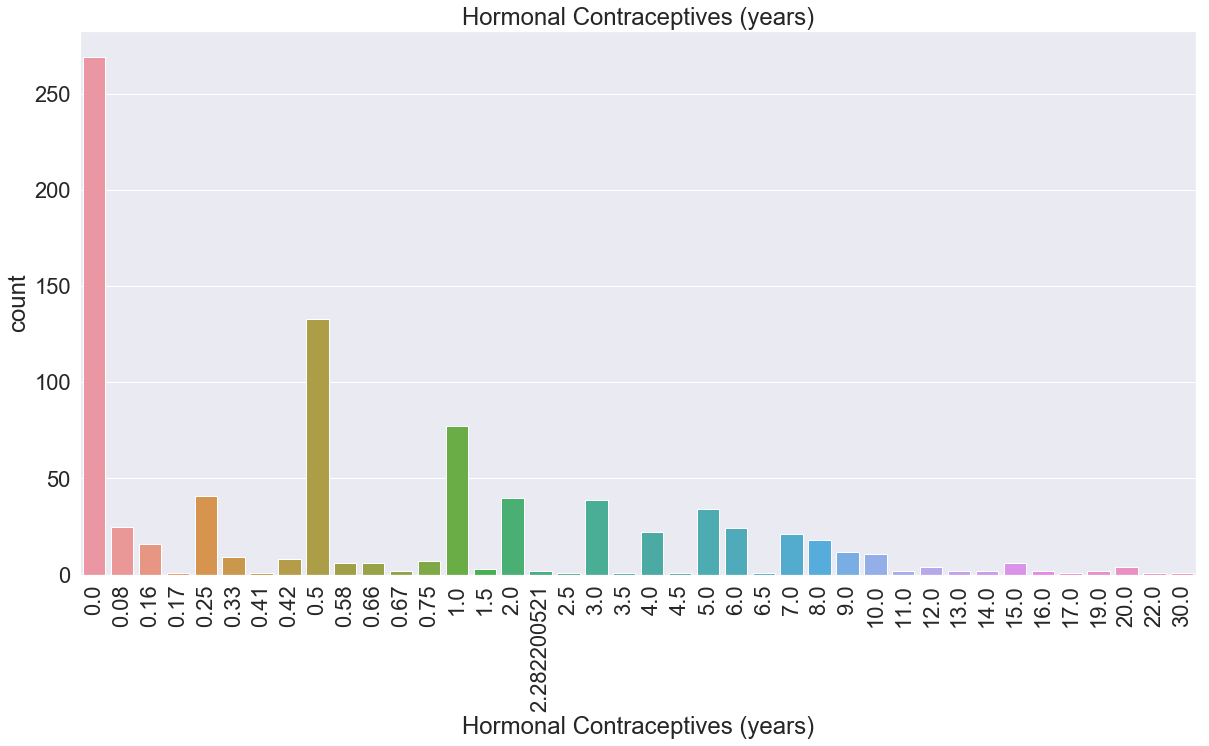



count    858.000000
mean       2.035331
std        3.567040
min        0.000000
25%        0.000000
50%        0.500000
75%        2.000000
max       30.000000
Name: Hormonal Contraceptives (years), dtype: float64
************************************************


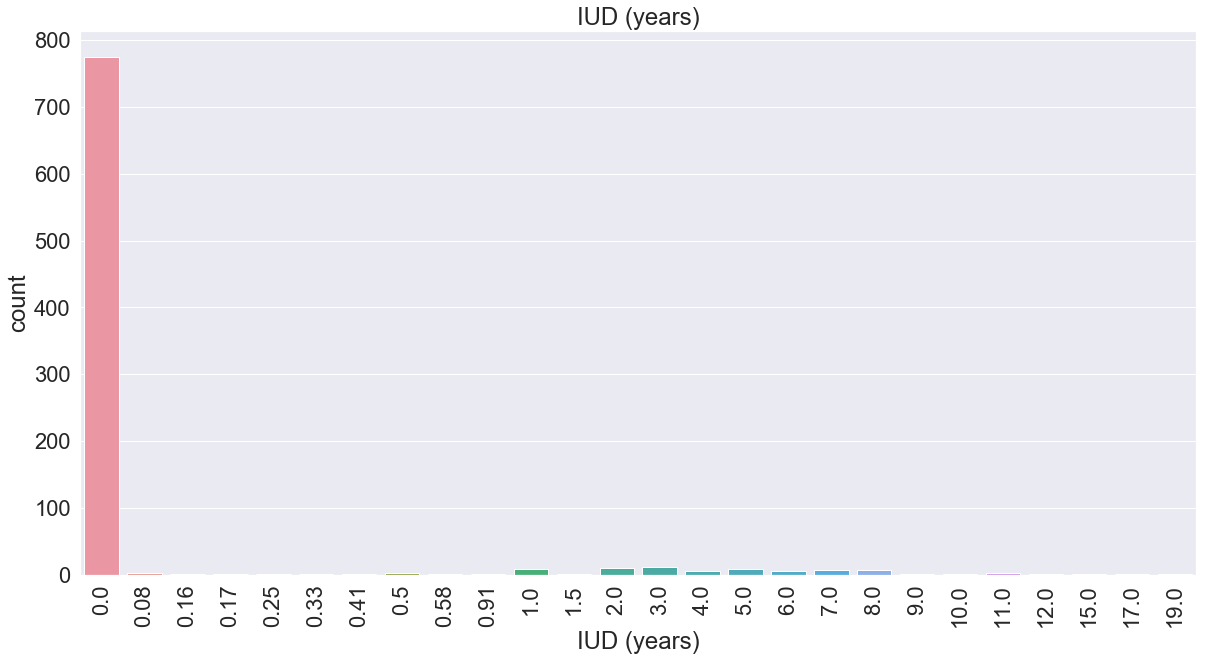



count    858.000000
mean       0.444604
std        1.814218
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       19.000000
Name: IUD (years), dtype: float64
************************************************


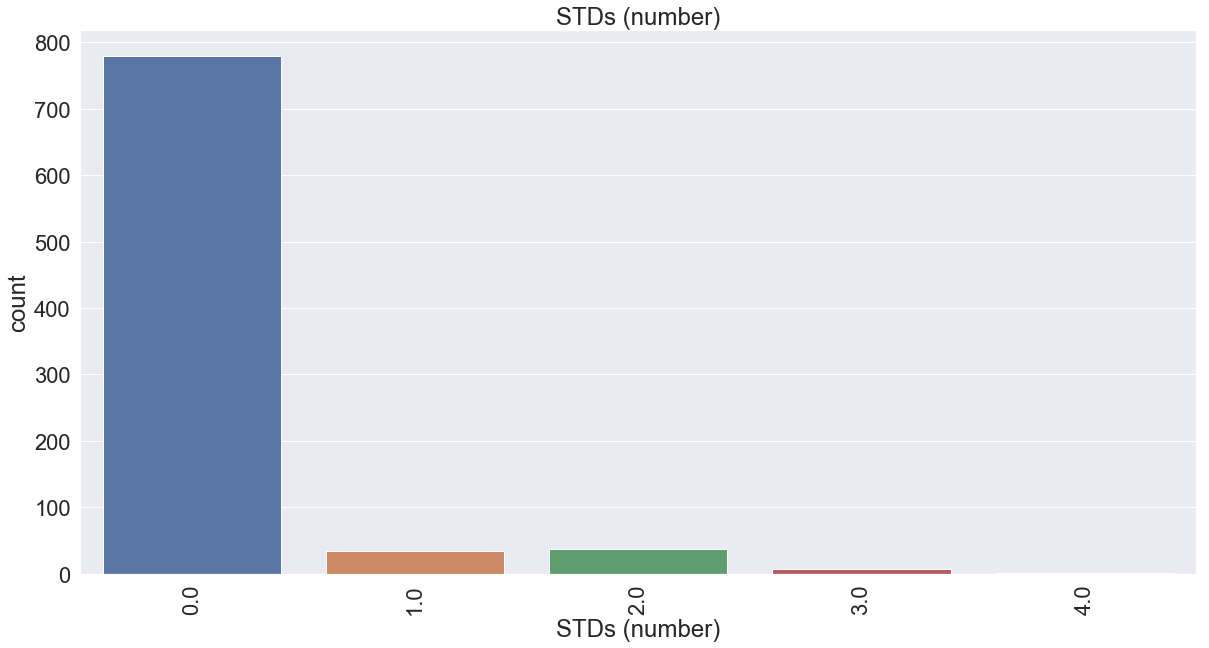



count    858.000000
mean       0.155012
std        0.529617
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: STDs (number), dtype: float64
************************************************


In [48]:
for col in continuous_cols:
    fig = plt.figure(figsize=(20,10))
    sns.countplot(x=col, data=df2)
    plt.title(col)
#     plt.xlabel(col[0],  )
    plt.xticks(rotation=90)
    plt.show()
    print("\n")
    print(df2[col].describe())
    print('************************************************')

Next step: Seperate the dataset into the predictive factors and the target variable 

In [232]:
# create X and y
X = df2.drop(['Biopsy'], axis=1)

y = df2['Biopsy']


In [235]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int64
Number of sexual partners             858 non-null float64
First sexual intercourse              858 non-null float64
Num of pregnancies                    858 non-null float64
Smokes                                858 non-null float64
Smokes (years)                        858 non-null float64
Smokes (packs/year)                   858 non-null float64
Hormonal Contraceptives               858 non-null float64
Hormonal Contraceptives (years)       858 non-null float64
IUD                                   858 non-null float64
IUD (years)                           858 non-null float64
STDs                                  858 non-null float64
STDs (number)                         858 non-null float64
STDs:condylomatosis                   858 non-null float64
STDs:vaginal condylomatosis           858 non-null float64
STDs:vulvo-p

In [51]:
X.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)',
       'STDs:condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:HIV', 'STDs:Hepatitis B',
       'STDs:HPV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann',
       'Schiller', 'Citology', 'is_number_partners_known',
       'is_first_intercourse_known', 'is_number_pregnancies_known',
       'Hormonal Contraceptives_0.0', 'Hormonal Contraceptives_1.0',
       'Hormonal Contraceptives_nan', 'IUD_0.0', 'IUD_1.0', 'IUD_nan',
       'STDs_0.0', 'STDs_1.0', 'STDs_nan'],
      dtype='object')

In [236]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Biopsy, dtype: int64

In [238]:
# create an 80/20 train/test split with a specified random value for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 10)


Next: Standardization or normalization for the numeric factors? 
If there is a difference in the range of values between factors, most machine learning models will not properly compensate for these differences and this can negatively impact performance. None of the numeric factors in this dataset:
* Age
* Number of sexual partners
* First sexual intercourse
* Num of pregnancies
* Smokes (years)
* Smokes (packs/years)
* Hormonal Contraceptives (years)
* IUD (years)
* STDs (number)
* STD's (number of diagnosis)
* STDs: Time since first diagnosis
* STDs: Time since last diagnosis

have a normal distribution. Only "Age" is remotely "normal". Accordingly I am choosing to standardize all fo these factors into a range from zero to 1. Standardization is done AFTER the test/train split so that the training dataset does not have the unrealistic advantage of information from the test data.

In [240]:
# standardize the continuous factors

minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))

X_train = pd.DataFrame(minmax_scale.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(minmax_scale.fit_transform(X_test), columns = X.columns)


Confirm that X and Y for both test and train sets have the same number of records.

In [244]:
print(X_train.shape)
print(y_train.shape)

(686, 36)
(686,)


In [245]:
print(X_test.shape)
print(y_test.shape)

(172, 36)
(172,)


Now look at the value counts for the target variable.

In [247]:
y_train.value_counts()

0    647
1     39
Name: Biopsy, dtype: int64

In [248]:
y_test.value_counts()

0    156
1     16
Name: Biopsy, dtype: int64

In both the test and train sets, the true value is a small percentage of the total records. This is referred to as an unbalanced dataset and can be more difficult to predict usign machine learning models. After some initial model tests additional tuning of parameters will be tested to compensate for the unbalanced target variable. I chose to explore the following models:
* Logistic Regression
* KNN ( K Nearest Neighbors)
* Decision Tree
* Random Forest
* SVM

# Logistic Regression

f1=0.211 auc=0.439 ap=0.459


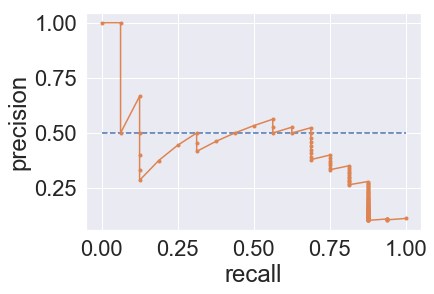

[[155   1]
 [ 14   2]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       156
           1       0.67      0.12      0.21        16

    accuracy                           0.91       172
   macro avg       0.79      0.56      0.58       172
weighted avg       0.89      0.91      0.88       172



In [64]:
# current block

model = LogisticRegression(fit_intercept = False,
                                C = 1e12,
                                class_weight='balanced',
                                solver='lbfgs',
                               max_iter = 4000)

model.fit(X_train, y_train)


# predict probabilities
probs = model.predict_proba(X_test)
# print("probs shape before drop zero: ", probs.shape)

# keep probabilities for the positive outcome only
probs = probs[:, 1]
# print("probs shape after drop zero: ", probs.shape)

# predict class values
preds = model.predict(X_test)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, preds)

# calculate precision-recall AUC
auc_score = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))


# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.xlabel('recall')
plt.ylabel('precision')

# show the plot
plt.show()

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

Very poor performance, this model generally performs worse at recall than randomly guessing.


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for None: 0.8878205128205128
LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for Balanced: 0.844551282051282
LogisticRegression(C=1000000000000.0, class_weight={0: 1, 1: 2}, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='warn', n_jobs=None, penalty='l2',
           

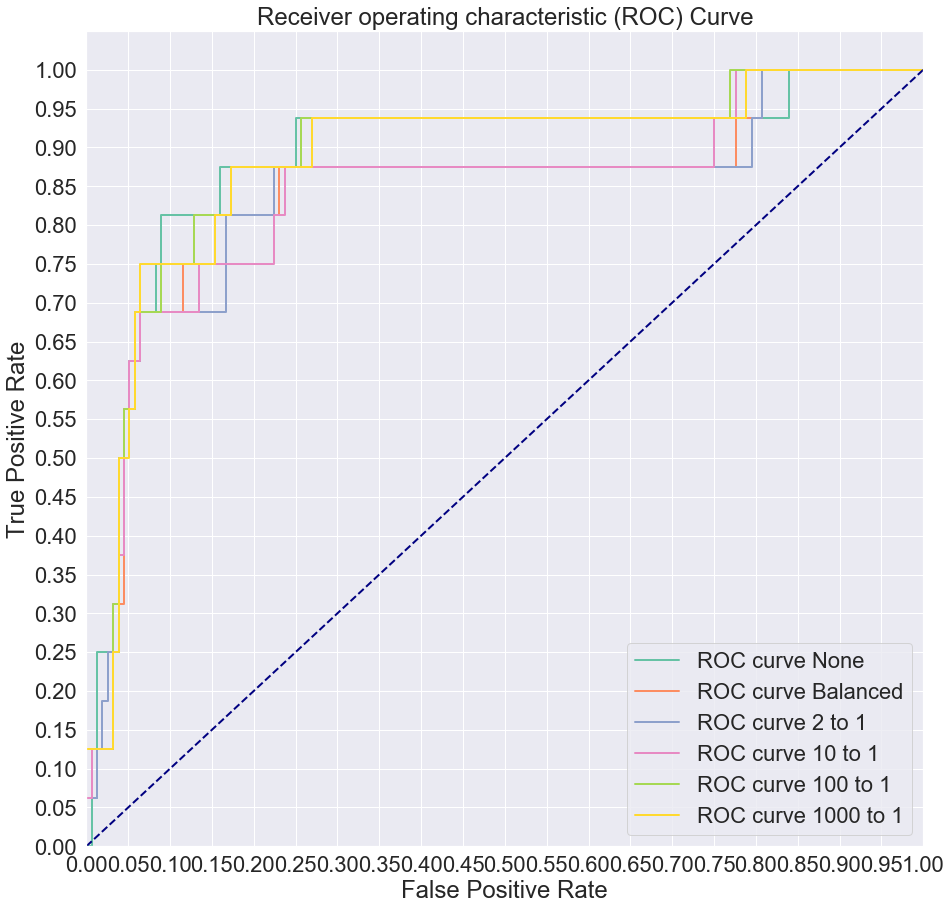

[[155   1]
 [ 14   2]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       156
           1       0.67      0.12      0.21        16

    accuracy                           0.91       172
   macro avg       0.79      0.56      0.58       172
weighted avg       0.89      0.91      0.88       172



In [65]:
# trying logistic regression with different weights
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette("Set2")

plt.figure(figsize=(15,15))

for n, weight in enumerate(weights):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False,
                                C = 1e12,
                                class_weight=weight,
                                solver='lbfgs',
                               max_iter = 4000) #Starter code
    
    model_log = logreg.fit(X_train, y_train)
    
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
#     precision, recall, thresholds = precision_recall_curve(y_test, y_score) # second argument is probas_pred
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

# KNN
K nearest neighbors doesn't work well with extremely unbalanced data like this. I will try the model with n_neighbors= 1 first. Then I will employ a different sampling method to create a "syntheticaly" balanced dataset.

In [66]:
# KNN
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[149   7]
 [ 10   6]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       156
           1       0.46      0.38      0.41        16

    accuracy                           0.90       172
   macro avg       0.70      0.67      0.68       172
weighted avg       0.89      0.90      0.90       172



In [67]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, preds)

Precision Score: 0.46153846153846156
Recall Score: 0.375
Accuracy Score: 0.9011627906976745
F1 Score: 0.41379310344827586


In [68]:
# find best K for f1 score
# https://en.wikipedia.org/wiki/F1_score

def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=5):
    best_k = 0
    best_score = 0.0
    
    for k in range(min_k, max_k+1, 1):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        print('k: {}'.format(k))
        print('F1-Score: {}'.format(f1))
        if f1 > best_score:
            best_k = k
            best_score = f1
    print('Best Value for k: {}'.format(best_k))
    print('F1-Score: {}'.format(best_score))

In [69]:
find_best_k(X_train, y_train, X_test, y_test)

k: 1
F1-Score: 0.41379310344827586
k: 2
F1-Score: 0.0
k: 3
F1-Score: 0.19047619047619047
k: 4
F1-Score: 0.0
k: 5
F1-Score: 0.2
Best Value for k: 1
F1-Score: 0.41379310344827586


In [70]:
# find best K for recall
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=5):
    best_k = 0
    best_score = 0.0
    
    for k in range(min_k, max_k+1, 1):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        recall = recall_score(y_test, preds)

        print('k: {}'.format(k))
        print('Recal Score: {}'.format(recall))
        if recall > best_score:
            best_k = k
            best_score = recall
    print('Best Value for k: {}'.format(best_k))
    print('Recall Score: {}'.format(best_score))

In [71]:
find_best_k(X_train, y_train, X_test, y_test)

k: 1
Recal Score: 0.375
k: 2
Recal Score: 0.0
k: 3
Recal Score: 0.125
k: 4
Recal Score: 0.0
k: 5
Recal Score: 0.125
Best Value for k: 1
Recall Score: 0.375


In [72]:
# because this is predicting cancer, it is far more preferable to not miss any positives, even if that means 
# getting more false positives. We simply do not want to miss any positives because the consequences could 
# result in death...
# So preference is given to a model that has a high recall (what percentage of actual cases of cancer did we capture in our prediction)
# This will mean more false positives (predicted as having cancer, but no cancer in reality), 
# but this is preferable to missing any cancer cases.




In [73]:
# Decision Tree 
tree_clf = DecisionTreeClassifier() 
# tree_clf.fit(X_train, y_train)

In [74]:
# lesson using gridsearch: dsc-3-32-06
dt_param_grid = {
    'class_weight': [None,'balanced'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 6, 7]}

dt_grid_search = GridSearchCV(tree_clf, 
                              param_grid = dt_param_grid, 
                              scoring = 'recall',
                              cv=3, 
                              return_train_score=True)

In [75]:
dt_grid_search.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                

In [76]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 95.94%
Mean Testing Score: 68.75%
Best Parameter Combination Found During Grid Search:


{'class_weight': None, 'criterion': 'gini', 'max_depth': 2}

In [77]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 2) 
tree_clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [78]:
tree_clf.fit(X_train, y_train)

preds = pd.DataFrame(tree_clf.predict(X_test))

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

print_metrics(y_test, preds)

[[149   7]
 [  5  11]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       156
           1       0.61      0.69      0.65        16

    accuracy                           0.93       172
   macro avg       0.79      0.82      0.80       172
weighted avg       0.93      0.93      0.93       172

Precision Score: 0.6111111111111112
Recall Score: 0.6875
Accuracy Score: 0.9302325581395349
F1 Score: 0.6470588235294118


In [79]:
tree_clf.feature_importances_

array([0.0886391 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04357246, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.86778844, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

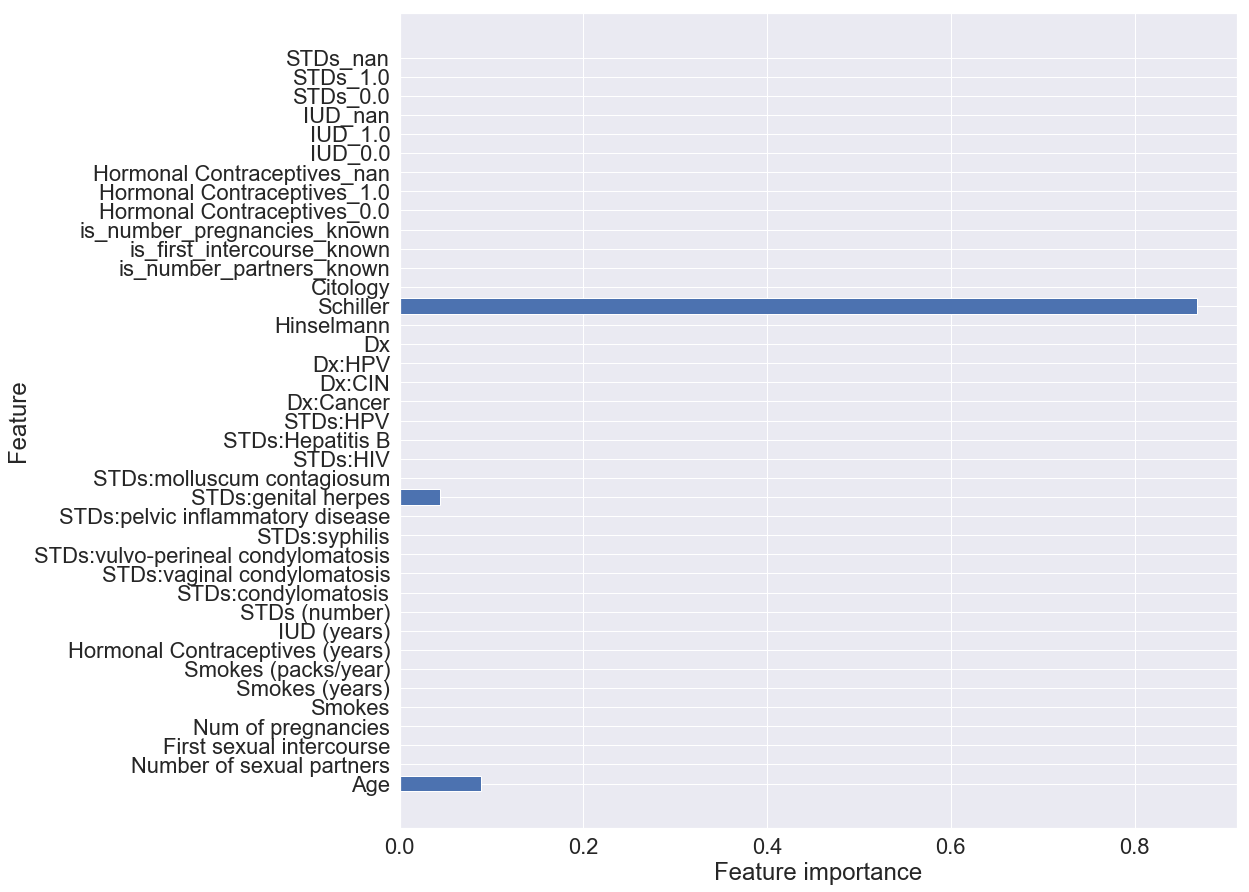

In [80]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(tree_clf)
plt.show()

In [81]:
y_test.value_counts(normalize=True)

0    0.906977
1    0.093023
Name: Biopsy, dtype: float64

In [82]:
preds[0].value_counts(normalize=True)


0    0.895349
1    0.104651
Name: 0, dtype: float64

In [83]:
# random forest

# forest = RandomForestClassifier(n_estimators=5, max_depth= 3, random_state=0)  #score: .9128
# forest = RandomForestClassifier(n_estimators=5, max_depth= 5, random_state=0)  #score: .8953
# forest = RandomForestClassifier(n_estimators=10, max_depth= 3, random_state=0)  #score: .9128
# forest = RandomForestClassifier(n_estimators=45, max_depth= 18, random_state=0)  #score: .9011
# forest = RandomForestClassifier(n_estimators=70, max_depth= 8, random_state=0)  #score: .9011
# forest = RandomForestClassifier(n_estimators=200, max_depth= 8, random_state=0)  #score: .9011

forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth= 5, random_state=0)

forest.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [84]:
preds = pd.DataFrame(forest.predict(X_test))
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print_metrics(y_test, preds)

[[150   6]
 [  6  10]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       156
           1       0.62      0.62      0.62        16

    accuracy                           0.93       172
   macro avg       0.79      0.79      0.79       172
weighted avg       0.93      0.93      0.93       172

Precision Score: 0.625
Recall Score: 0.625
Accuracy Score: 0.9302325581395349
F1 Score: 0.625


In [85]:
# use grid search for the random forest classifier, use recall as the factor to optimize
forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

forest_param_grid = {
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'n_estimators': [25, 50, 100, 200]}

forest_grid_search = GridSearchCV(forest, 
                                  param_grid = forest_param_grid, 
                                  scoring = 'recall',
                                  cv=3,
                                  return_train_score=True)

In [86]:
import time
start = time.time()

forest_grid_search.fit(X_train, y_train)

print("Testing Accuracy: {:.4}%".format(forest_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(forest_grid_search.best_params_))


Testing Accuracy: 87.18%
Total Runtime for Grid Search on Random Forest Classifier: 18.27 seconds

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 25}


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [87]:
forest = RandomForestClassifier(n_estimators=25, criterion='gini', max_depth=3, class_weight='balanced', random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=25, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [88]:
preds = forest.predict(X_test)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print_metrics(y_test, preds)

[[149   7]
 [  3  13]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       156
           1       0.65      0.81      0.72        16

    accuracy                           0.94       172
   macro avg       0.82      0.88      0.84       172
weighted avg       0.95      0.94      0.94       172

Precision Score: 0.65
Recall Score: 0.8125
Accuracy Score: 0.9418604651162791
F1 Score: 0.7222222222222223


In [89]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking by importance (best to worst):")

for f in range(X_train.shape[1]):
    print('{}  -  {}'.format(importances[indices[f]], X.columns[f]))


Feature ranking by importance (best to worst):
0.38156147569503845  -  Age
0.14605027725599265  -  Number of sexual partners
0.12186330610992525  -  First sexual intercourse
0.07373451150266269  -  Num of pregnancies
0.0408880559520167  -  Smokes
0.02885778936667957  -  Smokes (years)
0.022252926354971798  -  Smokes (packs/year)
0.019743133166129846  -  Hormonal Contraceptives (years)
0.019323090150091517  -  IUD (years)
0.016983404374382446  -  STDs (number)
0.014798303196180038  -  STDs:condylomatosis
0.014687091167886608  -  STDs:vaginal condylomatosis
0.01293619053948214  -  STDs:vulvo-perineal condylomatosis
0.012632097736580448  -  STDs:syphilis
0.0101308623037267  -  STDs:pelvic inflammatory disease
0.009996498751552107  -  STDs:genital herpes
0.009681679697343263  -  STDs:molluscum contagiosum
0.008800326517694265  -  STDs:HIV
0.008705647045606777  -  STDs:Hepatitis B
0.004875190099640068  -  STDs:HPV
0.004512792499081504  -  Dx:Cancer
0.0038403519158178656  -  Dx:CIN
0.0034955

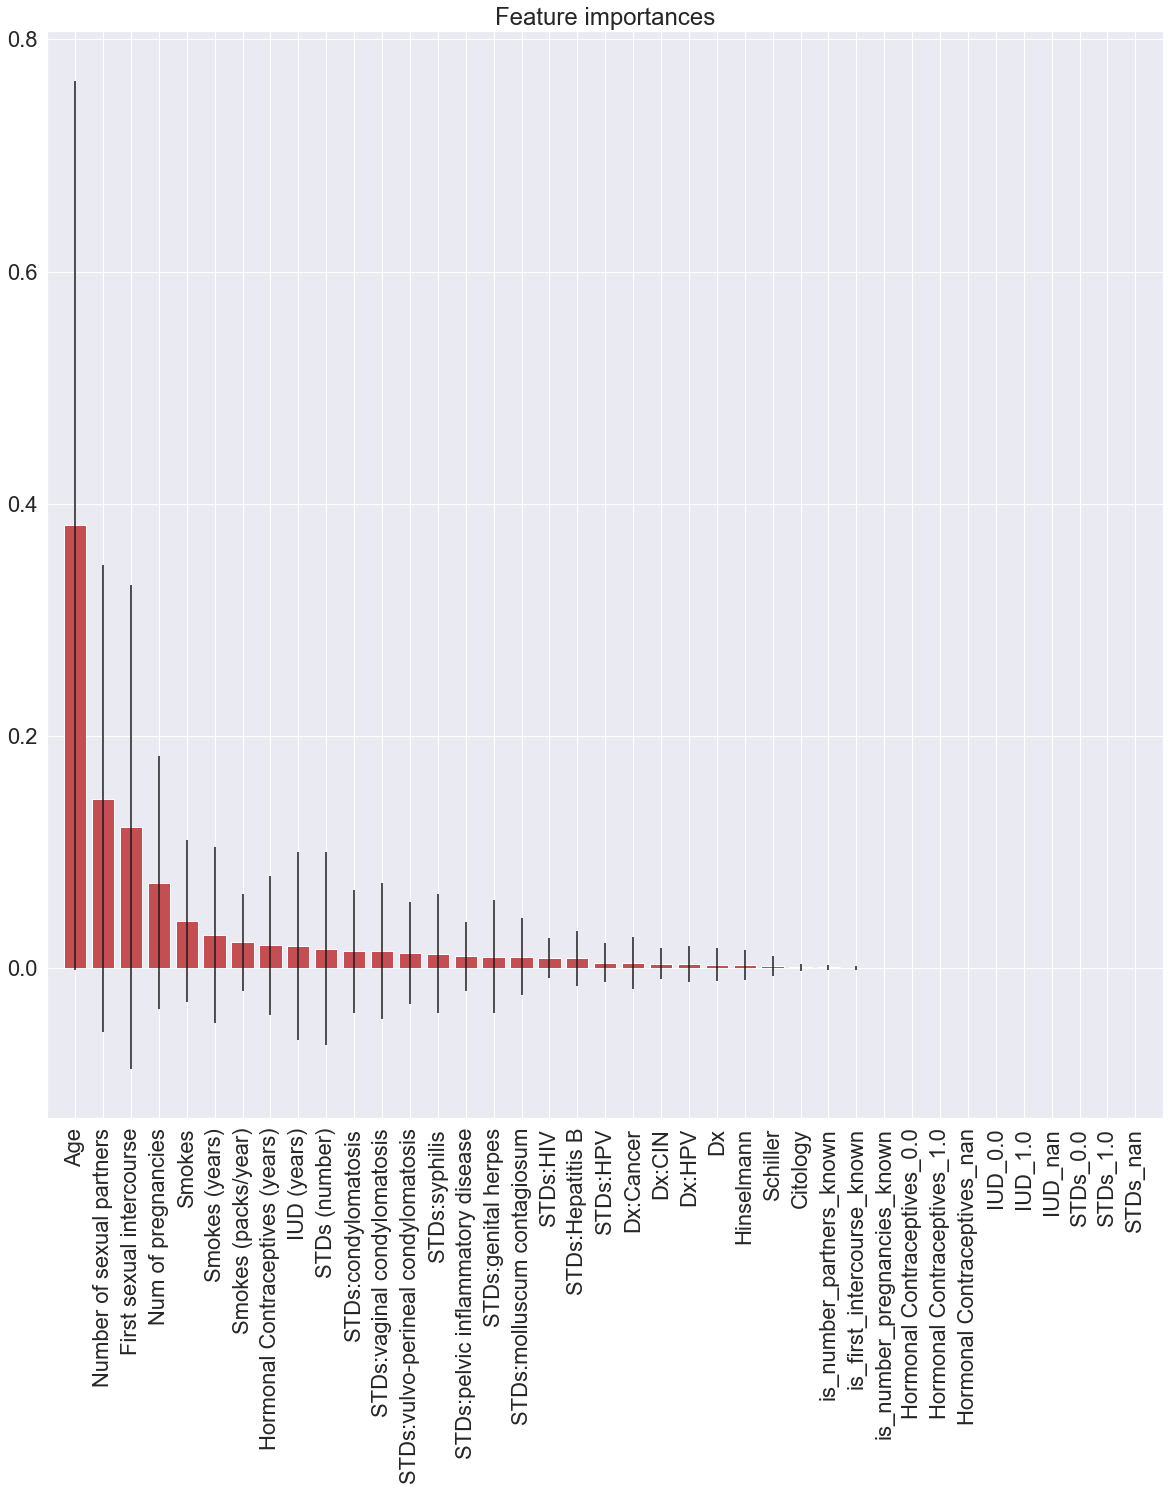

In [90]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,20))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Idea: Delete the other target variables and run the same gridsearch then see what the results for the resulting best tree.

In [91]:
from imblearn.combine import SMOTETomek

In [92]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 10)


# standardize the continuous factors
# minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
# X_train_scaled = pd.DataFrame(minmax_scale.fit_transform(X_train))
# X_test_scaled = pd.DataFrame(minmax_scale.fit_transform(X_test))

# X_train_scaled = X_train  #this model works better when I don't scale the non-categorical factors ???
# X_test_scaled = X_test


cc = SMOTETomek(random_state=10)

X_res, y_res = (X_train, y_train)


In [93]:
X_res = pd.DataFrame(X_res)

In [94]:
X_res.shape

(686, 39)

In [95]:
y_res.value_counts()

0    647
1     39
Name: Biopsy, dtype: int64

Now that I have resampled using SMOTE, use grid search to find the best parameters for a random forest.

In [98]:
# use grid search for the random forest classifier, use recall as the factor to optimize
forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0, n_jobs=-1)

forest_param_grid = {
    'class_weight': [None, 'balanced', {0:1, 1:10}],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 6],
    'n_estimators': [10, 15, 20, 25]}

forest_grid_search = GridSearchCV(forest, 
                                  param_grid = forest_param_grid, 
                                  scoring = 'recall',
                                  cv=3,
                                  return_train_score=True)

In [99]:
import time
start = time.time()

forest_grid_search.fit(X_res, y_res)

print("Testing Accuracy: {:.4}%".format(forest_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(forest_grid_search.best_params_))

Testing Accuracy: 87.18%
Total Runtime for Grid Search on Random Forest Classifier: 85.12 seconds

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10}


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [123]:
forest = RandomForestClassifier(n_estimators=10, 
                                criterion='gini',
                                class_weight='balanced', 
                                max_depth=2,
                                random_state=0, 
                                n_jobs=-1)

forest.fit(X_res, y_res)

preds = forest.predict(X_test)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print_metrics(y_test, preds)

[[148   8]
 [  2  14]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       156
           1       0.64      0.88      0.74        16

    accuracy                           0.94       172
   macro avg       0.81      0.91      0.85       172
weighted avg       0.95      0.94      0.95       172

Precision Score: 0.6363636363636364
Recall Score: 0.875
Accuracy Score: 0.9418604651162791
F1 Score: 0.7368421052631579


In [102]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking by importance (best to worst):")

for f in range(X_train.shape[1]):
    print('{}  -  {}'.format(importances[indices[f]], X.columns[f]))


Feature ranking by importance (best to worst):
0.6142448058259562  -  Age
0.17926556688555317  -  Number of sexual partners
0.06562749100471366  -  First sexual intercourse
0.04666141160074528  -  Num of pregnancies
0.022954870430351028  -  Smokes
0.01601978364572571  -  Smokes (years)
0.014222165085402718  -  Smokes (packs/year)
0.01285739340999365  -  Hormonal Contraceptives (years)
0.01076912661064802  -  IUD (years)
0.008568238210632064  -  STDs (number)
0.004631844260676249  -  STDs:condylomatosis
0.002738427900322609  -  STDs:vaginal condylomatosis
0.0014388751292796823  -  STDs:vulvo-perineal condylomatosis
0.0  -  STDs:syphilis
0.0  -  STDs:pelvic inflammatory disease
0.0  -  STDs:genital herpes
0.0  -  STDs:molluscum contagiosum
0.0  -  STDs:HIV
0.0  -  STDs:Hepatitis B
0.0  -  STDs:HPV
0.0  -  Dx:Cancer
0.0  -  Dx:CIN
0.0  -  Dx:HPV
0.0  -  Dx
0.0  -  Hinselmann
0.0  -  Schiller
0.0  -  Citology
0.0  -  is_number_partners_known
0.0  -  is_first_intercourse_known
0.0  -  is_nu

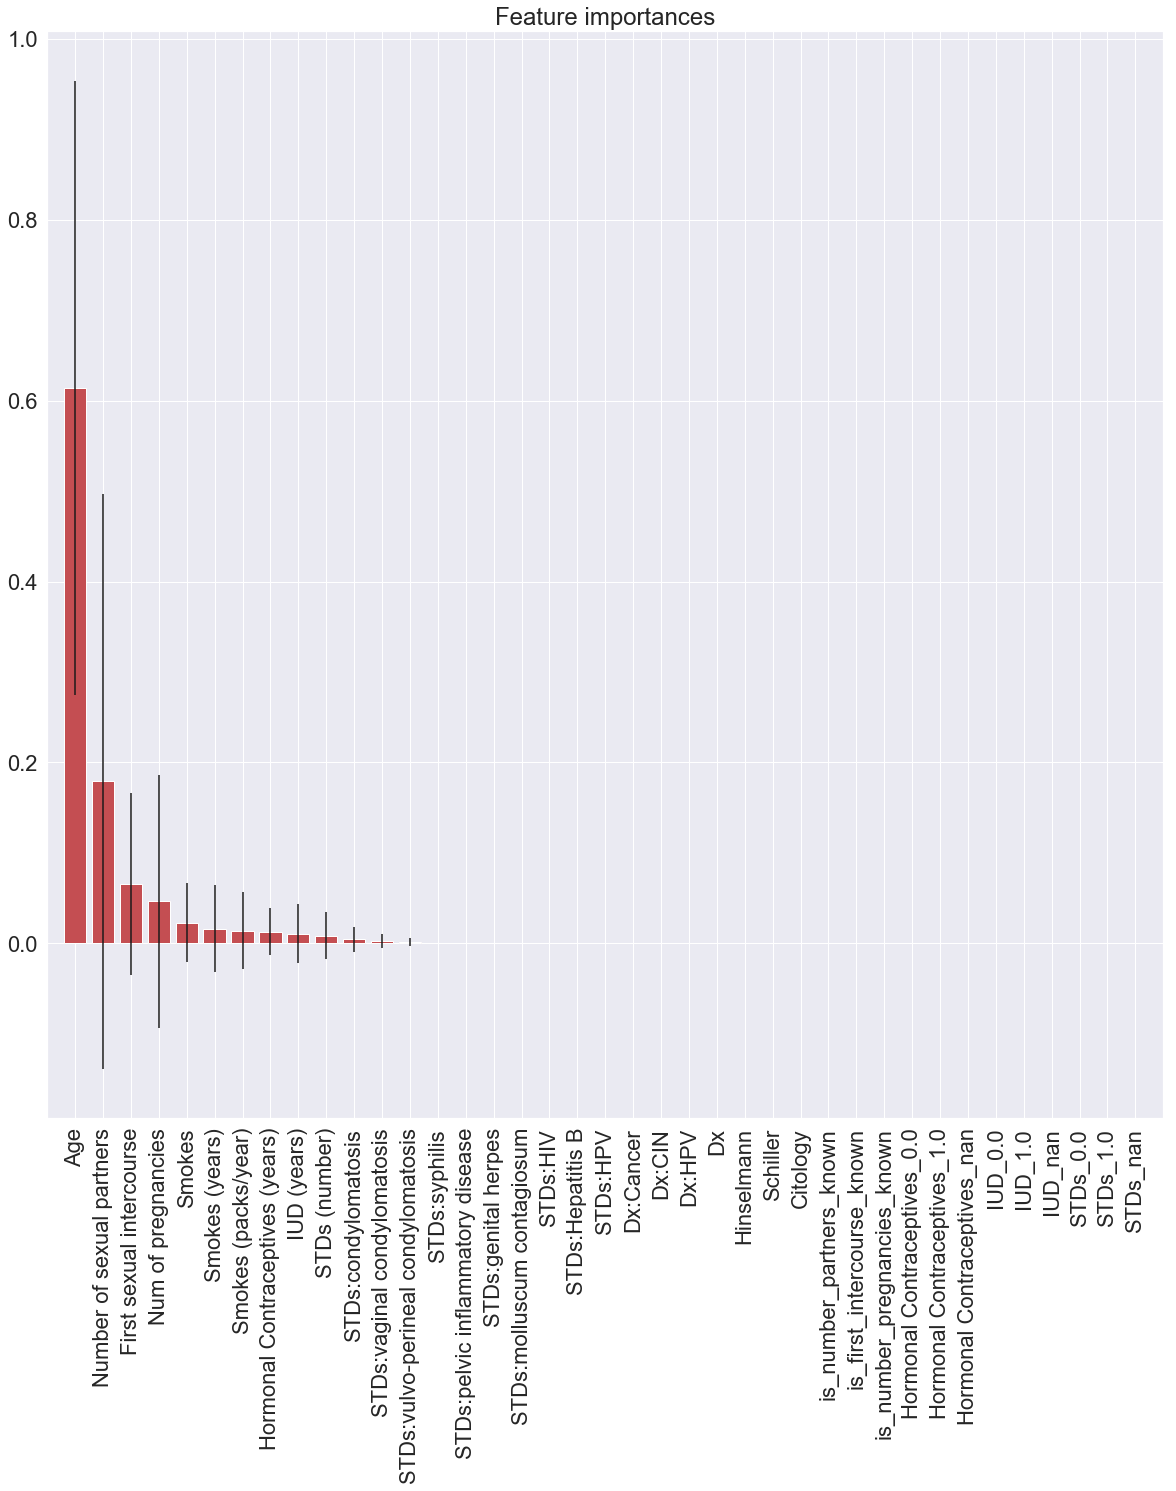

In [103]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,20))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# SVM

In [105]:
# base SVM
clf = svm.SVC(cache_size=1000, gamma='scale')
clf

SVC(C=1.0, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [106]:
clf.fit(X_train, y_train)  
preds = clf.predict(X_test)

In [107]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[150   6]
 [ 10   6]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       156
           1       0.50      0.38      0.43        16

    accuracy                           0.91       172
   macro avg       0.72      0.67      0.69       172
weighted avg       0.90      0.91      0.90       172



In [108]:
#set class_weight to balanced
clf = svm.SVC(cache_size=1000, gamma='scale', class_weight='balanced')
clf

SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [109]:
clf.fit(X_train, y_train)  
preds = clf.predict(X_test)

In [110]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[147   9]
 [  3  13]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       156
           1       0.59      0.81      0.68        16

    accuracy                           0.93       172
   macro avg       0.79      0.88      0.82       172
weighted avg       0.94      0.93      0.94       172



In [111]:
#try with resampled data
clf = svm.SVC(cache_size=1000, gamma='scale', class_weight='balanced')
clf

SVC(C=1.0, cache_size=1000, class_weight={0: 1, 1: 10}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [125]:
clf.fit(X_res, y_res)  
preds = clf.predict(X_test)

In [126]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[147   9]
 [  3  13]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       156
           1       0.59      0.81      0.68        16

    accuracy                           0.93       172
   macro avg       0.79      0.88      0.82       172
weighted avg       0.94      0.93      0.94       172



In [114]:
# run a new SVM after dropping the other target columns
X_train.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),...,is_number_pregnancies_known,Hormonal Contraceptives_0.0,Hormonal Contraceptives_1.0,Hormonal Contraceptives_nan,IUD_0.0,IUD_1.0,IUD_nan,STDs_0.0,STDs_1.0,STDs_nan
0,0.183099,0.074074,0.409091,0.181818,0.0,0.0,0.0,0.166667,0.0,0.00,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.267606,0.000000,0.545455,0.181818,0.0,0.0,0.0,0.233333,0.0,0.00,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.056338,0.037037,0.227273,0.181818,0.0,0.0,0.0,0.000000,0.0,0.75,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.098592,0.074074,0.272727,0.363636,0.0,0.0,0.0,0.100000,0.0,0.00,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.197183,0.185185,0.318182,0.181818,0.0,0.0,0.0,0.000000,0.0,0.00,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [115]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 39 columns):
Age                                   686 non-null float64
Number of sexual partners             686 non-null float64
First sexual intercourse              686 non-null float64
Num of pregnancies                    686 non-null float64
Smokes                                686 non-null float64
Smokes (years)                        686 non-null float64
Smokes (packs/year)                   686 non-null float64
Hormonal Contraceptives (years)       686 non-null float64
IUD (years)                           686 non-null float64
STDs (number)                         686 non-null float64
STDs:condylomatosis                   686 non-null float64
STDs:vaginal condylomatosis           686 non-null float64
STDs:vulvo-perineal condylomatosis    686 non-null float64
STDs:syphilis                         686 non-null float64
STDs:pelvic inflammatory disease      686 non-null float64
STDs:genit

In [116]:
X_train_2 = X_train.drop(['Hinselmann', 'Schiller', 'Citology'], axis=1 )
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 36 columns):
Age                                   686 non-null float64
Number of sexual partners             686 non-null float64
First sexual intercourse              686 non-null float64
Num of pregnancies                    686 non-null float64
Smokes                                686 non-null float64
Smokes (years)                        686 non-null float64
Smokes (packs/year)                   686 non-null float64
Hormonal Contraceptives (years)       686 non-null float64
IUD (years)                           686 non-null float64
STDs (number)                         686 non-null float64
STDs:condylomatosis                   686 non-null float64
STDs:vaginal condylomatosis           686 non-null float64
STDs:vulvo-perineal condylomatosis    686 non-null float64
STDs:syphilis                         686 non-null float64
STDs:pelvic inflammatory disease      686 non-null float64
STDs:genit

In [117]:
X_test_2 = X_test.drop(['Hinselmann', 'Schiller', 'Citology'], axis=1 )
X_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 36 columns):
Age                                   172 non-null float64
Number of sexual partners             172 non-null float64
First sexual intercourse              172 non-null float64
Num of pregnancies                    172 non-null float64
Smokes                                172 non-null float64
Smokes (years)                        172 non-null float64
Smokes (packs/year)                   172 non-null float64
Hormonal Contraceptives (years)       172 non-null float64
IUD (years)                           172 non-null float64
STDs (number)                         172 non-null float64
STDs:condylomatosis                   172 non-null float64
STDs:vaginal condylomatosis           172 non-null float64
STDs:vulvo-perineal condylomatosis    172 non-null float64
STDs:syphilis                         172 non-null float64
STDs:pelvic inflammatory disease      172 non-null float64
STDs:genit

In [118]:
clf = svm.SVC(cache_size=1000, gamma='scale', class_weight='balanced')
clf

SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [127]:
clf.fit(X_train_2, y_train)  
preds = clf.predict(X_test_2)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[143  13]
 [ 12   4]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       156
           1       0.24      0.25      0.24        16

    accuracy                           0.85       172
   macro avg       0.58      0.58      0.58       172
weighted avg       0.86      0.85      0.86       172



Precision stays high but recall drops off a cliff when I remove the other target variables...despite those variables being listed as very low importance...why?


Try a random forest on the new factors list (no other targets.)

In [128]:
forest = RandomForestClassifier(n_estimators=10, 
                                criterion='gini',
                                class_weight='balanced', 
                                max_depth=2,
                                random_state=0, 
                                n_jobs=-1)

forest.fit(X_train_2, y_train)

preds = forest.predict(X_test_2)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print_metrics(y_test, preds)


[[139  17]
 [ 10   6]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       156
           1       0.26      0.38      0.31        16

    accuracy                           0.84       172
   macro avg       0.60      0.63      0.61       172
weighted avg       0.87      0.84      0.86       172

Precision Score: 0.2608695652173913
Recall Score: 0.375
Accuracy Score: 0.8430232558139535
F1 Score: 0.30769230769230765


Try SMOTE resampling on the new factors list (other target variables removed) 

In [129]:
# X_res = resampled X_test
# y_res = resampled y_test


X_train_res_2 = X_res.drop(['Hinselmann', 'Schiller', 'Citology'], axis=1 )
X_test_2 = X_test.drop(['Hinselmann', 'Schiller', 'Citology'], axis=1 )


In [131]:
forest.fit(X_train_res_2, y_res)

preds = forest.predict(X_test_2)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print_metrics(y_test, preds)



[[139  17]
 [ 10   6]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       156
           1       0.26      0.38      0.31        16

    accuracy                           0.84       172
   macro avg       0.60      0.63      0.61       172
weighted avg       0.87      0.84      0.86       172

Precision Score: 0.2608695652173913
Recall Score: 0.375
Accuracy Score: 0.8430232558139535
F1 Score: 0.30769230769230765


# STOP HERE

In [135]:
# from https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn

from IPython.display import SVG
graph = Source( forest.export_graphviz(dtreg, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

NameError: name 'Source' is not defined

In [132]:
# from https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn

from graphviz import Source
from sklearn import tree
Source( tree.export_graphviz(dtreg, out_file=None, feature_names=X.columns))

ModuleNotFoundError: No module named 'graphviz'

In [128]:
!pip list

Package              Version  
-------------------- ---------
absl-py              0.7.1    
appnope              0.1.0    
asn1crypto           0.24.0   
astor                0.8.0    
atomicwrites         1.3.0    
attrs                19.1.0   
backcall             0.1.0    
beautifulsoup4       4.7.1    
bleach               3.1.0    
bokeh                1.2.0    
boto                 2.49.0   
boto3                1.9.134  
botocore             1.12.153 
branca               0.3.1    
bz2file              0.98     
certifi              2019.6.16
cffi                 1.11.5   
chardet              3.0.4    
convertdate          2.1.3    
cryptography         2.3.1    
cryptography-vectors 2.3.1    
cycler               0.10.0   
Cython               0.28.5   
decorator            4.3.0    
defusedxml           0.6.0    
docutils             0.14     
entrypoints          0.3      
ephem                3.7.6.0  
fbprophet            0.5      
folium               0.9.1    
gast    

In [121]:
# from dsc-3-31-07
from sklearn import tree 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus



/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


ModuleNotFoundError: No module named 'pydotplus'

In [ ]:
dot_data = StringIO()
export_graphviz(classifier2, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())